In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/原油加工量.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
sheet.columns


Index(['中国汽油+柴油+煤油+石脑油+燃料油产量', '原油：加工量：中国（月）\t', '中国石脑油产量',
       '中国石油苯+PX+PP+PE月度产量（预测/主观预估）', '燃料油：产量：中国（月）', '成品油：山东独立炼厂：利润（周）/4WMA',
       'Kpler-中国原油进口量（中质酸油+重质酸油）', '柴油：产量：中国（月）', '煤油：产量：中国（月）',
       '中国汽柴油实际消费量/4WMA同差', 'WTI原油期货价格', '国内+国际航班执行数/7DMA(预测/上一年季节性)',
       '人民币汇率收盘价', '中国柴油实际消费量（周度）/4WMA同差', '中国与美国10年国债利差', '南华黑色指数同比',
       '中国10年期国债收益率同差', 'A股地产指数/沪深300 20日环比', 'LME铜价/WTI原油期货价格', '中国汽油实际消费量',
       '汽油：产量：中国（月）', '山东汽油裂解差60日环差', '汽油情绪指数/4WMA', 'DR007利率/5DMA', 'LME铜价',
       '中国柴油实际消费量', '中国新能源车渗透率同差',
       '山东汽油裂解差-（烷基化汽油：市场价：山东（日）-汽油：国六：92#：市场价：山东（日））', '中国独立炼厂柴油库存/中国柴油实际消费量',
       'Kpler-中国中重质原油进口量', '纯电动重卡月度渗透率'],
      dtype='object')

In [5]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/wti_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/wti_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['wti原油期货价格'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.tail()

,Date,WTI原油期货价格预测
4,2025-11-17,45.44
3,2025-11-18,48.44
2,2025-11-19,46.97
1,2025-11-20,48.79
0,2025-11-21,48.79


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/铜/eta/LME铜价_合并数据.xlsx"),    
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/铜/eta/LME铜价_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.read_excel(file_path2, sheet_name='Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['真实值'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
    sheet2.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")
sheet2.tail()

,Date,预测值
4,2025-11-17,10734.0
3,2025-11-18,10717.0
2,2025-11-19,10701.6
1,2025-11-20,10706.7
0,2025-11-21,10703.8


In [7]:
file_path3 = os.path.expanduser("eta/中国柴油实际消费量(多因子)_合并数据.xlsx") 
sheet3 = pd.ExcelFile(file_path3).parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.drop(columns=['真实值'])
sheet3 = sheet3.dropna()

sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3.tail()

,Date,预测值
4,2025-11-17,440.3019
3,2025-11-18,435.9701
2,2025-11-19,422.2689
1,2025-11-20,432.6345
0,2025-11-21,425.4032


In [8]:
file_path4 = os.path.expanduser("eta/中国汽油实际消费量(多因子)_合并数据.xlsx") 
sheet4 = pd.ExcelFile(file_path4).parse('Sheet1')
sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
sheet4 = sheet4.drop(columns=['真实值'])
sheet4 = sheet4.dropna()

sheet4 = sheet4.sort_values('Date', ascending=True)
sheet4.tail()

,Date,预测值
4,2025-12-01,300.5837
3,2025-12-02,301.0322
2,2025-12-03,302.4242
1,2025-12-04,316.0534
0,2025-12-05,316.1836


In [9]:
sheet.columns

Index(['中国汽油+柴油+煤油+石脑油+燃料油产量', '原油：加工量：中国（月）\t', '中国石脑油产量',
       '中国石油苯+PX+PP+PE月度产量（预测/主观预估）', '燃料油：产量：中国（月）', '成品油：山东独立炼厂：利润（周）/4WMA',
       'Kpler-中国原油进口量（中质酸油+重质酸油）', '柴油：产量：中国（月）', '煤油：产量：中国（月）',
       '中国汽柴油实际消费量/4WMA同差', 'WTI原油期货价格', '国内+国际航班执行数/7DMA(预测/上一年季节性)',
       '人民币汇率收盘价', '中国柴油实际消费量（周度）/4WMA同差', '中国与美国10年国债利差', '南华黑色指数同比',
       '中国10年期国债收益率同差', 'A股地产指数/沪深300 20日环比', 'LME铜价/WTI原油期货价格', '中国汽油实际消费量',
       '汽油：产量：中国（月）', '山东汽油裂解差60日环差', '汽油情绪指数/4WMA', 'DR007利率/5DMA', 'LME铜价',
       '中国柴油实际消费量', '中国新能源车渗透率同差',
       '山东汽油裂解差-（烷基化汽油：市场价：山东（日）-汽油：国六：92#：市场价：山东（日））', '中国独立炼厂柴油库存/中国柴油实际消费量',
       'Kpler-中国中重质原油进口量', '纯电动重卡月度渗透率'],
      dtype='object')

In [10]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', 'WTI原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['WTI原油期货价格'] = sheet_daily['WTI原油期货价格'].fillna(sheet_daily['WTI原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['WTI原油期货价格预测'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['LME铜价'] = sheet_daily['LME铜价'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily['LME铜价/WTI原油期货价格_预测'] = sheet_daily['LME铜价']/sheet_daily['WTI原油期货价格']
sheet_daily['LME铜价/WTI原油期货价格'] = sheet_daily['LME铜价/WTI原油期货价格'].fillna(sheet_daily['LME铜价/WTI原油期货价格_预测'])
sheet_daily = sheet_daily.drop(columns=['LME铜价/WTI原油期货价格_预测'])

# sheet 3
sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['中国柴油实际消费量'] = sheet_daily['中国柴油实际消费量'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# sheet 4
sheet_daily = pd.merge(
    sheet_daily,
    sheet4[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['中国汽油实际消费量'] = sheet_daily['中国汽油实际消费量'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily['中国汽柴油实际消费量'] = sheet_daily['中国汽油实际消费量'] + sheet_daily['中国柴油实际消费量']
sheet_daily['中国汽柴油实际消费量/4WMA'] = sheet_daily['中国汽柴油实际消费量'].rolling(window=4).mean()
sheet_daily['中国汽柴油实际消费量/4WMA同差_预测'] = sheet_daily['中国汽柴油实际消费量/4WMA'].diff()
sheet_daily['中国汽柴油实际消费量/4WMA同差'] = sheet_daily['中国汽柴油实际消费量/4WMA同差'].fillna(sheet_daily['中国汽柴油实际消费量/4WMA同差_预测'])
sheet_daily = sheet_daily.drop(columns=['中国汽柴油实际消费量/4WMA同差_预测'])
# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')
sheet.tail(10)

,中国汽油+柴油+煤油+石脑油+燃料油产量,原油：加工量：中国（月）\t,中国石脑油产量,中国石油苯+PX+PP+PE月度产量（预测/主观预估）,燃料油：产量：中国（月）,成品油：山东独立炼厂：利润（周）/4WMA,Kpler-中国原油进口量（中质酸油+重质酸油）,柴油：产量：中国（月）,煤油：产量：中国（月）,中国汽柴油实际消费量/4WMA同差,...,DR007利率/5DMA,LME铜价,中国柴油实际消费量,中国新能源车渗透率同差,山东汽油裂解差-（烷基化汽油：市场价：山东（日）-汽油：国六：92#：市场价：山东（日））,中国独立炼厂柴油库存/中国柴油实际消费量,Kpler-中国中重质原油进口量,纯电动重卡月度渗透率,中国汽柴油实际消费量,中国汽柴油实际消费量/4WMA
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:

last_day = sheet['原油：加工量：中国（月）\t'].last_valid_index()
# 将日期索引转换为datetime格式
sheet.index = pd.to_datetime(sheet.index)

# 对于特定列使用最后一个有效值,其他列使用指数衰减加权平均
lambda_ = 0.95
no_decay_cols = ['中国汽油+柴油+煤油+石脑油+燃料油产量', '原油：加工量：中国（月）\t', '中国石脑油产量',
                 '燃料油：产量：中国（月）', '柴油：产量：中国（月）', '煤油：产量：中国（月）', '汽油：产量：中国（月）']

# 对这些列进行缺失值填充
for col in no_decay_cols:
    sheet[col] = sheet[col].ffill()  # 用前值填充

def custom_resample(x):
    if x.name in no_decay_cols:
        return x.iloc[-1] if len(x) > 0 else np.nan
    else:
        weights = lambda_ ** np.arange(len(x)-1, -1, -1)
        return (x * weights).sum() / weights.sum()

sheet = sheet.resample('ME').apply(custom_resample)

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day, periods=2, freq='ME')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day, end=target_end, freq='ME')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]
sheet.columns


Index(['中国汽油+柴油+煤油+石脑油+燃料油产量', '原油：加工量：中国（月）\t', '中国石脑油产量',
       '中国石油苯+PX+PP+PE月度产量（预测/主观预估）', '燃料油：产量：中国（月）', '成品油：山东独立炼厂：利润（周）/4WMA',
       'Kpler-中国原油进口量（中质酸油+重质酸油）', '柴油：产量：中国（月）', '煤油：产量：中国（月）',
       '中国汽柴油实际消费量/4WMA同差', 'WTI原油期货价格', '国内+国际航班执行数/7DMA(预测/上一年季节性)',
       '人民币汇率收盘价', '中国柴油实际消费量（周度）/4WMA同差', '中国与美国10年国债利差', '南华黑色指数同比',
       '中国10年期国债收益率同差', 'A股地产指数/沪深300 20日环比', 'LME铜价/WTI原油期货价格', '中国汽油实际消费量',
       '汽油：产量：中国（月）', '山东汽油裂解差60日环差', '汽油情绪指数/4WMA', 'DR007利率/5DMA', 'LME铜价',
       '中国柴油实际消费量', '中国新能源车渗透率同差',
       '山东汽油裂解差-（烷基化汽油：市场价：山东（日）-汽油：国六：92#：市场价：山东（日））', '中国独立炼厂柴油库存/中国柴油实际消费量',
       'Kpler-中国中重质原油进口量', '纯电动重卡月度渗透率', '中国汽柴油实际消费量', '中国汽柴油实际消费量/4WMA'],
      dtype='object')

In [12]:
################################# 处理缺失值 #################################
'''
fill_methods = {
'LME铜价': 'interpolate', 
'人民币汇率收盘价': 'interpolate', 
'秦皇岛动力煤价格' : 'interpolate' 
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')
'''
#################################  因子处理  #################################
#汽油产量因子
sheet['山东汽油裂解差60日环差_提前1月'] = sheet['山东汽油裂解差60日环差'].shift(1)
sheet['汽油情绪指数/4WMA_提前1月'] = sheet['汽油情绪指数/4WMA'].shift(1)
sheet['DR007利率/5DMA_提前1月'] = sheet['DR007利率/5DMA'].shift(1)
sheet['中国新能源车渗透率同差_提前2月'] = sheet['中国新能源车渗透率同差'].shift(2)
sheet['山东汽油裂解差-（烷基化汽油：市场价：山东（日）-汽油：国六：92#：市场价：山东（日））_提前2月'] = reverse_column(sheet, '山东汽油裂解差-（烷基化汽油：市场价：山东（日）-汽油：国六：92#：市场价：山东（日））')

sheet['中国新能源车渗透率同差_提前2月_逆序'] = reverse_column(sheet, '中国新能源车渗透率同差_提前2月')
#柴油产量因子
sheet['中国柴油实际消费量（周度）/4WMA同差_提前1月'] = sheet['中国柴油实际消费量（周度）/4WMA同差'].shift(1)
sheet['中国与美国10年国债利差_提前2月'] = sheet['中国与美国10年国债利差'].shift(2)
sheet['南华黑色指数同比_提前6月'] = sheet['南华黑色指数同比'].shift(6)
sheet['中国10年期国债收益率同差_提前3月'] = sheet['中国10年期国债收益率同差'].shift(3)
sheet['A股地产指数/沪深300 20日环比_提前2月'] = sheet['A股地产指数/沪深300 20日环比'].shift(2)
sheet['中国独立炼厂柴油库存/中国柴油实际消费量_提前1月'] = sheet['中国独立炼厂柴油库存/中国柴油实际消费量'].shift(1)
sheet['Kpler-中国中重质原油进口量_提前1月'] = sheet['Kpler-中国中重质原油进口量'].shift(1)
sheet['纯电动重卡月度渗透率_提前2月'] = sheet['纯电动重卡月度渗透率'].shift(2)

sheet['中国独立炼厂柴油库存/中国柴油实际消费量_提前1月_逆序'] = reverse_column(sheet, '中国独立炼厂柴油库存/中国柴油实际消费量_提前1月')
sheet['LME铜价/WTI原油期货价格_逆序'] = reverse_column(sheet, 'LME铜价/WTI原油期货价格')
sheet['纯电动重卡月度渗透率_提前2月_逆序'] = reverse_column(sheet, '纯电动重卡月度渗透率_提前2月')

#煤油产量因子
sheet['WTI原油期货价格_提前3月'] = sheet['WTI原油期货价格'].shift(3)
sheet['国内+国际航班执行数/7DMA(预测/上一年季节性)_提前1月'] = sheet['国内+国际航班执行数/7DMA(预测/上一年季节性)'].shift(1)
sheet['人民币汇率收盘价_提前2月'] = sheet['人民币汇率收盘价'].shift(2)

sheet['柴油：产量：中国（月）_逆序'] = reverse_column(sheet, '柴油：产量：中国（月）')
sheet['WTI原油期货价格_提前3月_逆序'] = reverse_column(sheet, 'WTI原油期货价格_提前3月')

#燃料油产量因子
sheet['成品油：山东独立炼厂：利润（周）/4WMA_提前1月'] = sheet['成品油：山东独立炼厂：利润（周）/4WMA'].shift(1)
sheet['Kpler-中国原油进口量（中质酸油+重质酸油）_提前5月'] = sheet['Kpler-中国原油进口量（中质酸油+重质酸油）'].shift(5)


################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2022-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['原油：加工量：中国（月）\t'].notna())
]
# 需要置空的列
columns_to_null = [
    '中国汽油+柴油+煤油+石脑油+燃料油产量',
    '原油：加工量：中国（月）\t',
    '中国石脑油产量',
    '燃料油：产量：中国（月）',
    '柴油：产量：中国（月）',
    '煤油：产量：中国（月）',
    '汽油：产量：中国（月）'
]

# 将每个列的最后一个非空值置为空
for col in columns_to_null:
    last_valid_idx = sheet_daily[col].last_valid_index()
    if last_valid_idx is not None:
        sheet_daily.loc[last_valid_idx, col] = np.nan

################################# 数据 读取-处理 结束 #################################

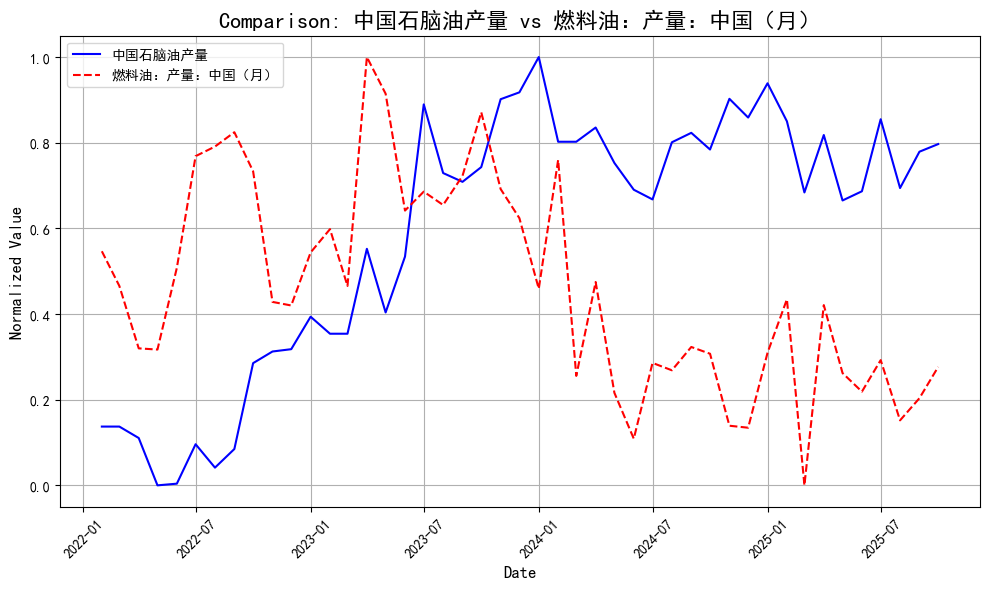

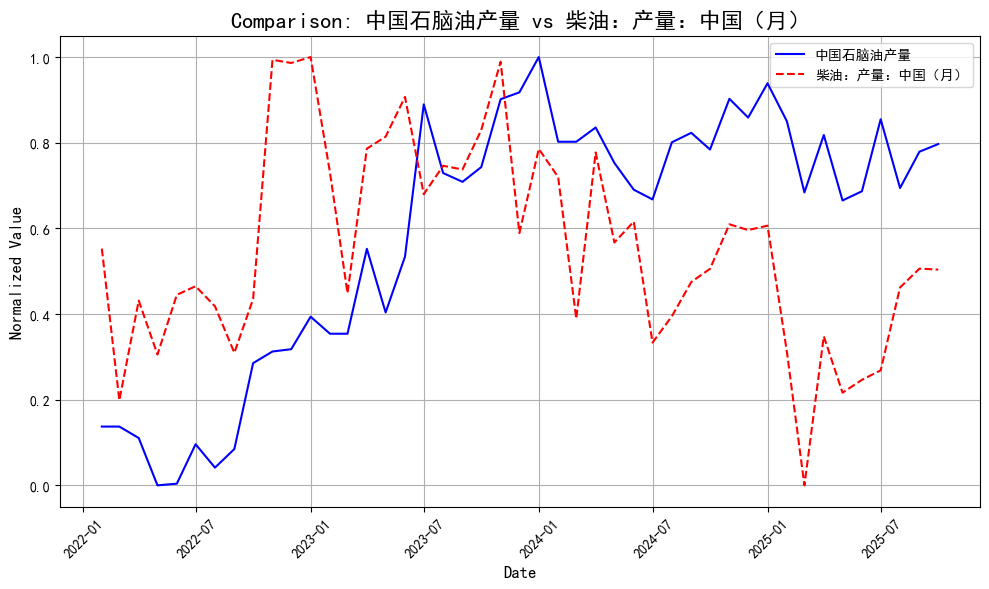

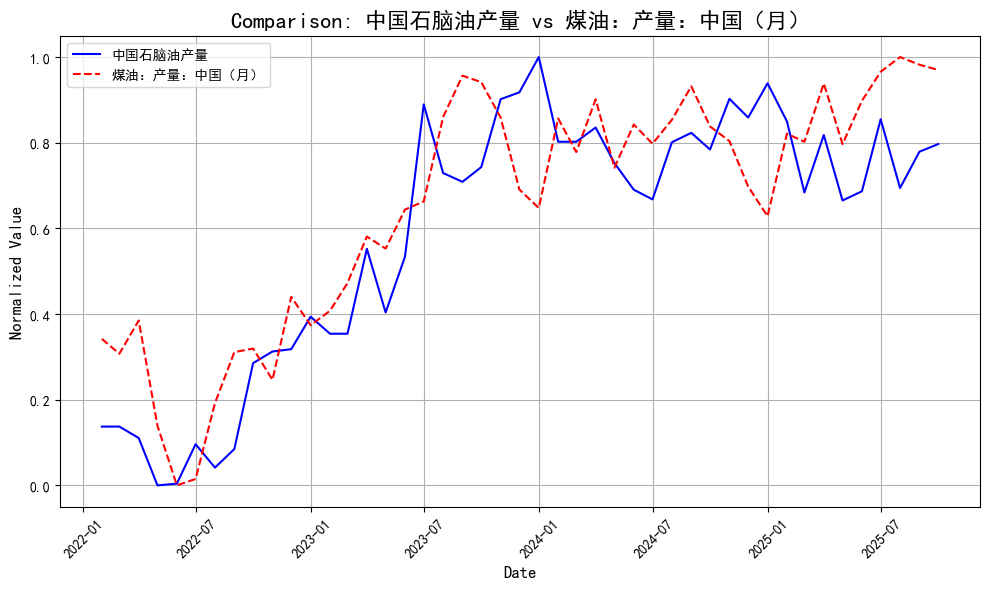

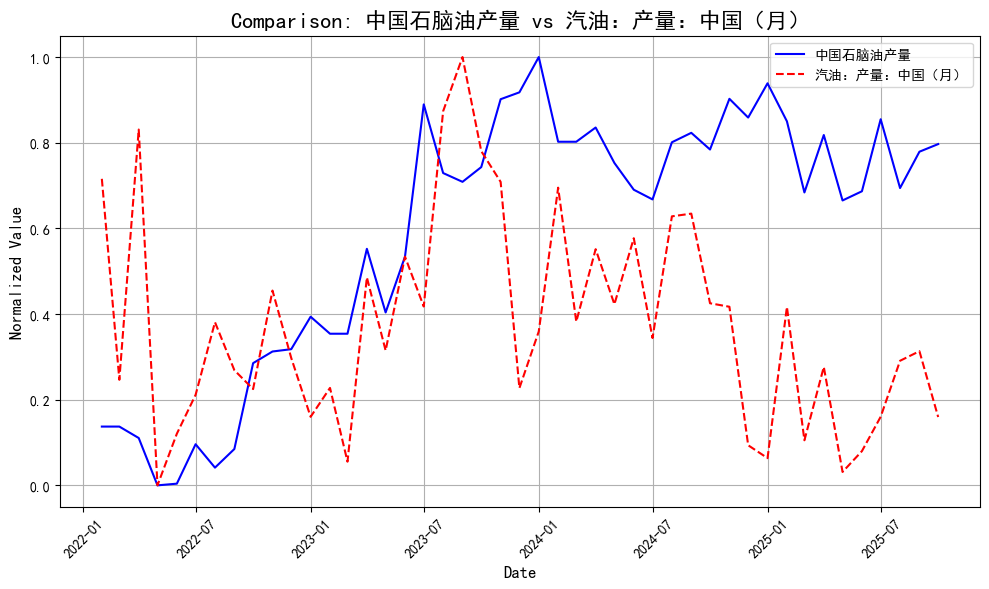

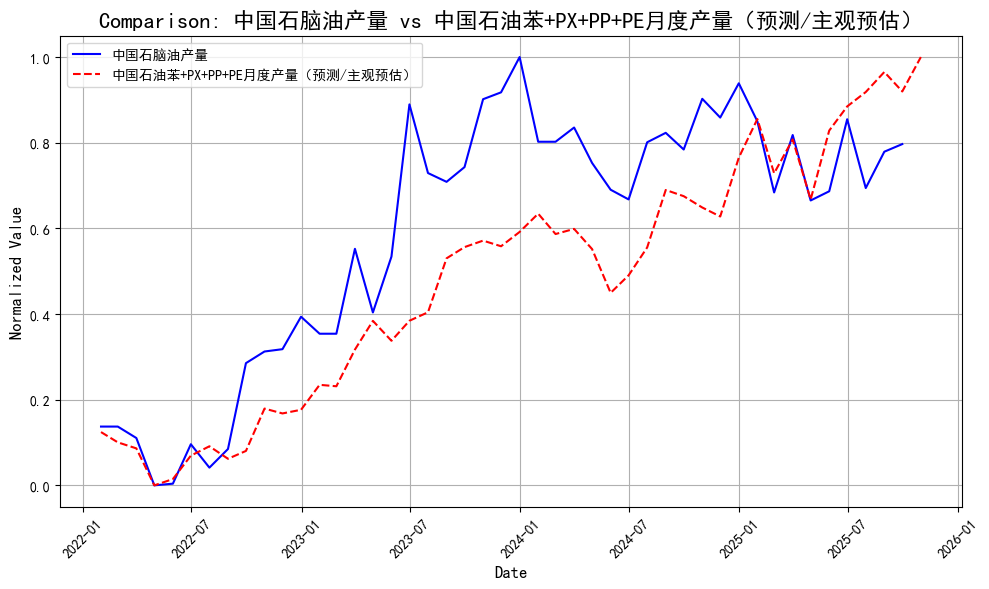

In [13]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='中国石脑油产量', 
    compare_cols=[
         '燃料油：产量：中国（月）',
    '柴油：产量：中国（月）',
    '煤油：产量：中国（月）',
    '汽油：产量：中国（月）',
    '中国石油苯+PX+PP+PE月度产量（预测/主观预估）'
        ]
)

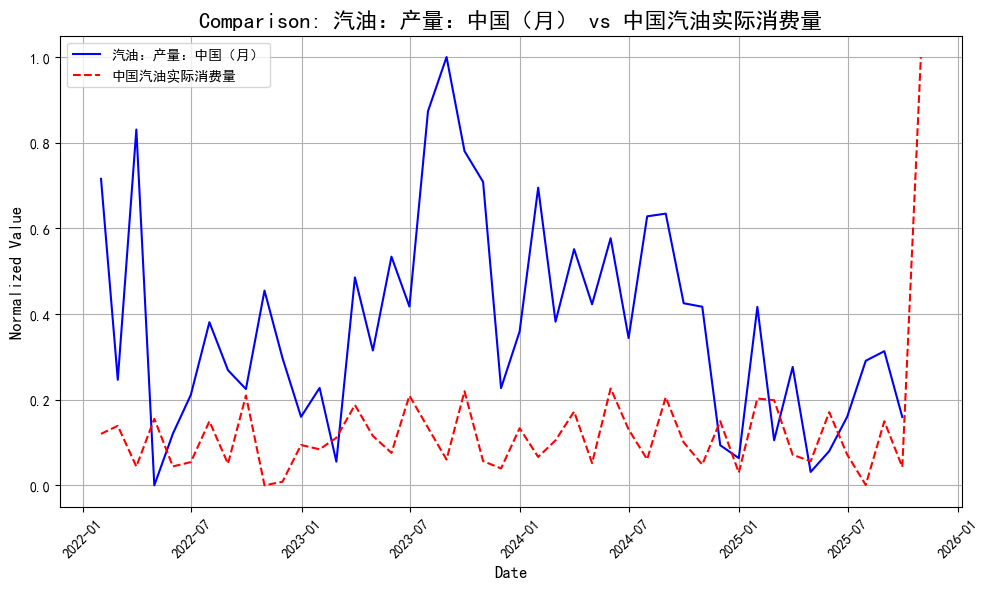

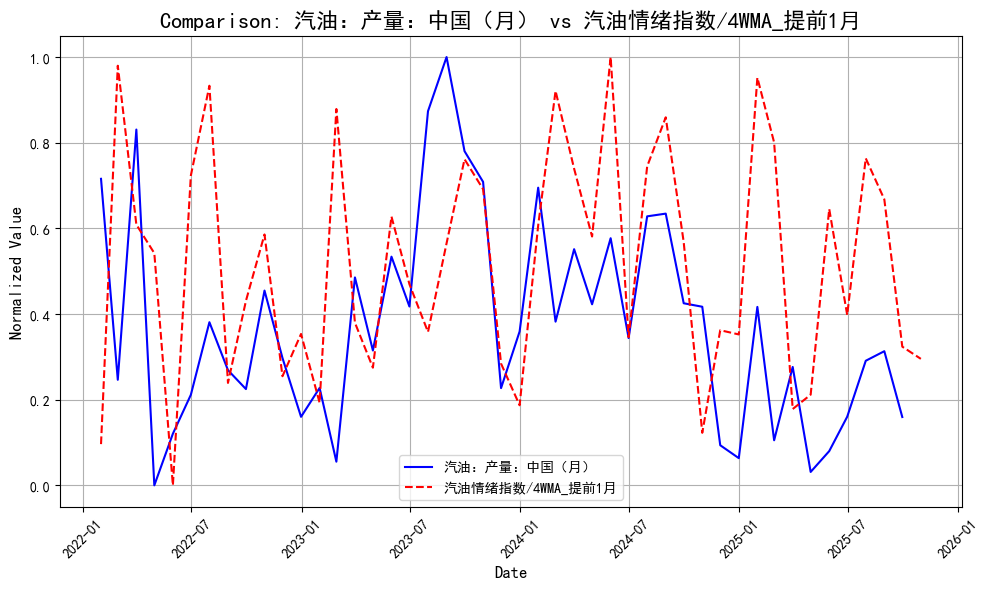

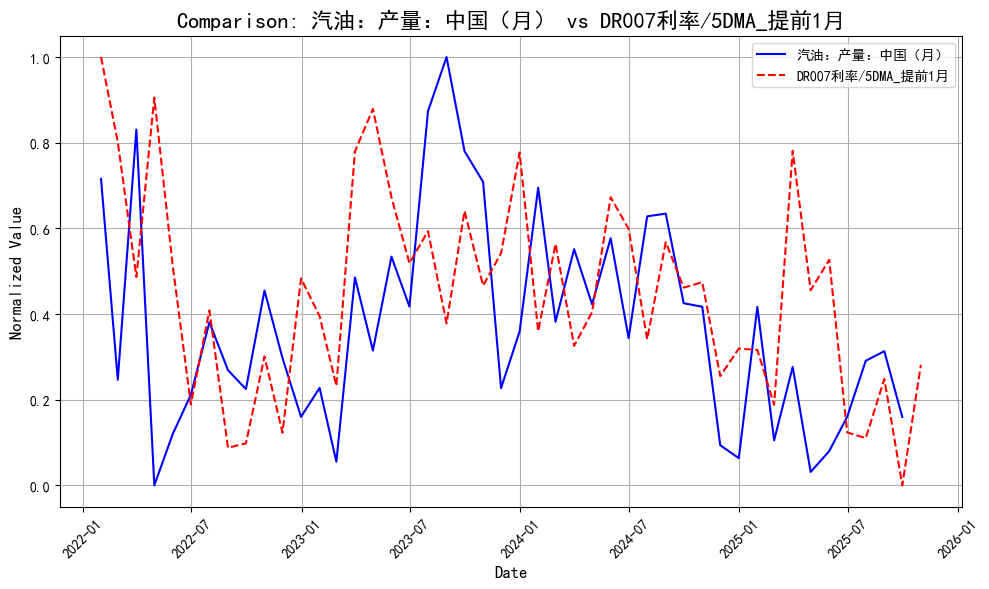

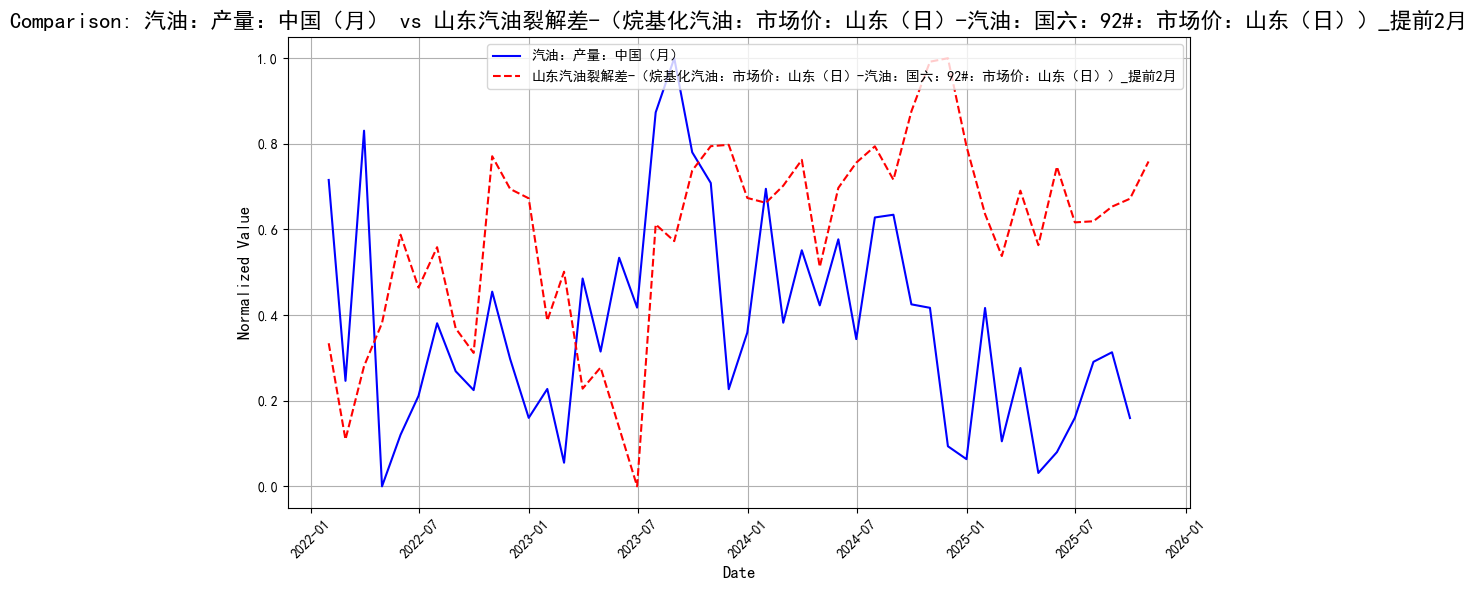

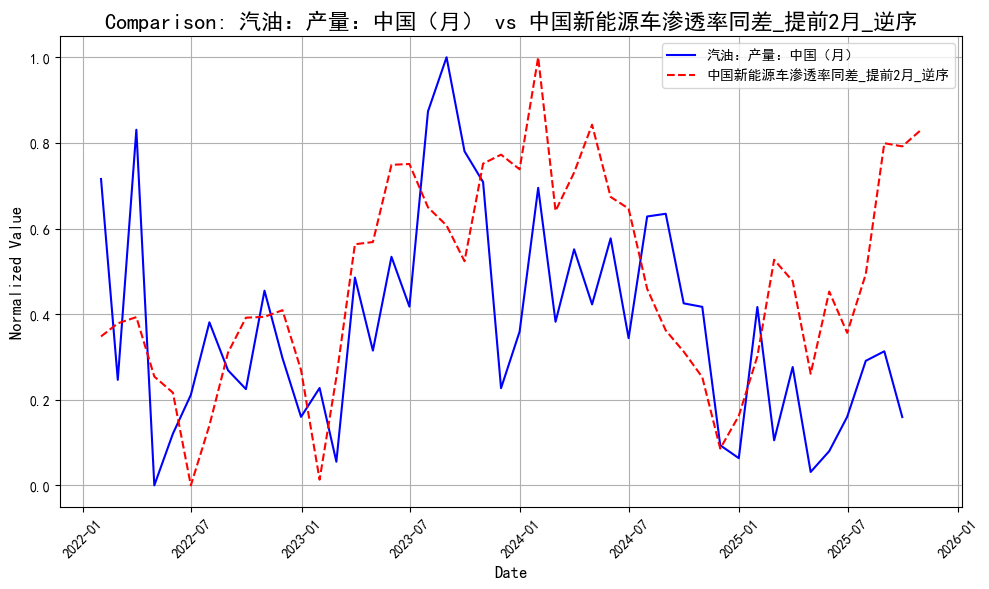

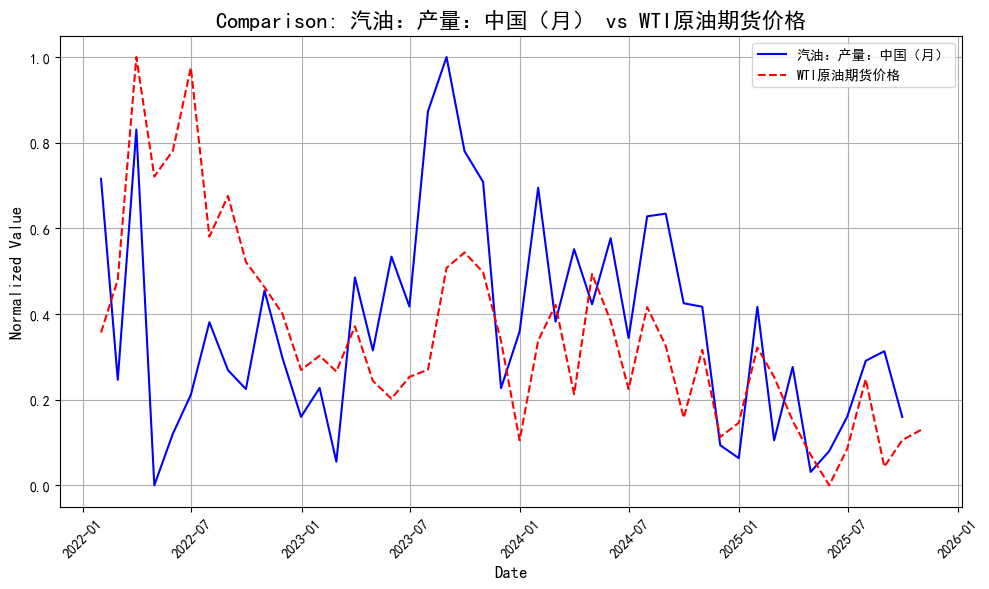

In [14]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='汽油：产量：中国（月）', 
    compare_cols=[
        '中国汽油实际消费量', 
        '汽油情绪指数/4WMA_提前1月',
        'DR007利率/5DMA_提前1月',
        '山东汽油裂解差-（烷基化汽油：市场价：山东（日）-汽油：国六：92#：市场价：山东（日））_提前2月',
        '中国新能源车渗透率同差_提前2月_逆序',
        'WTI原油期货价格'
        ]
)

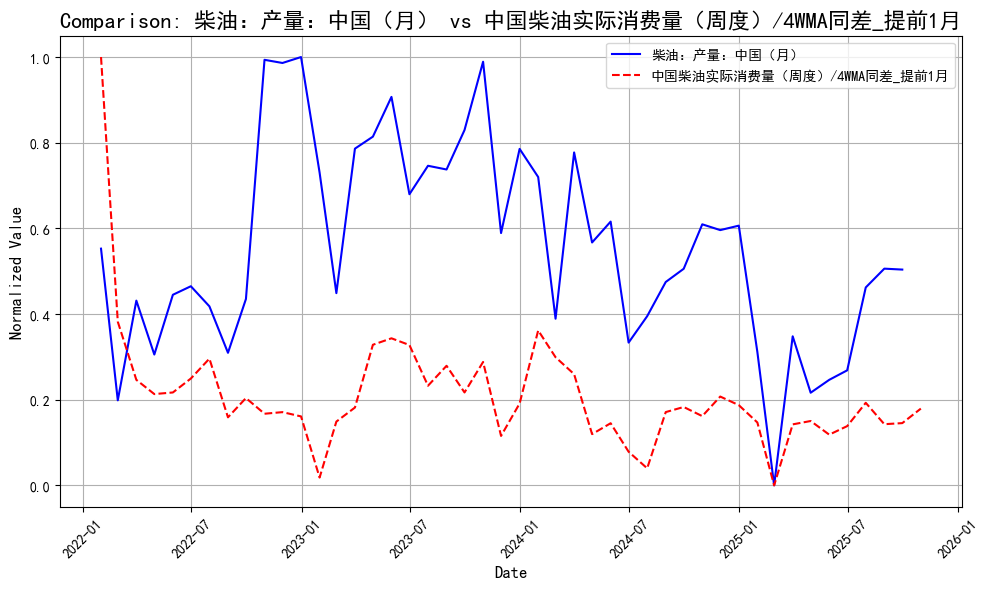

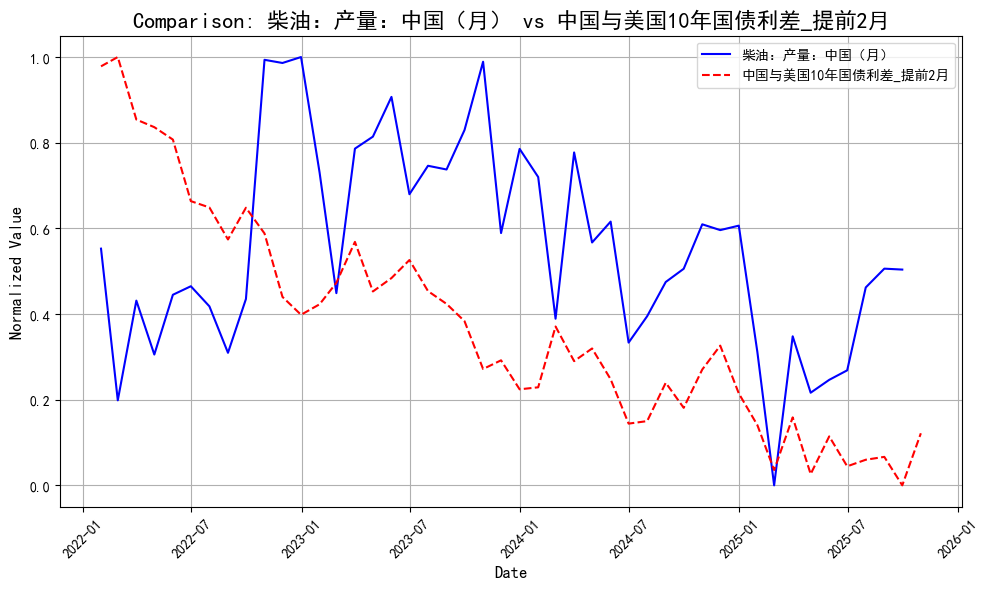

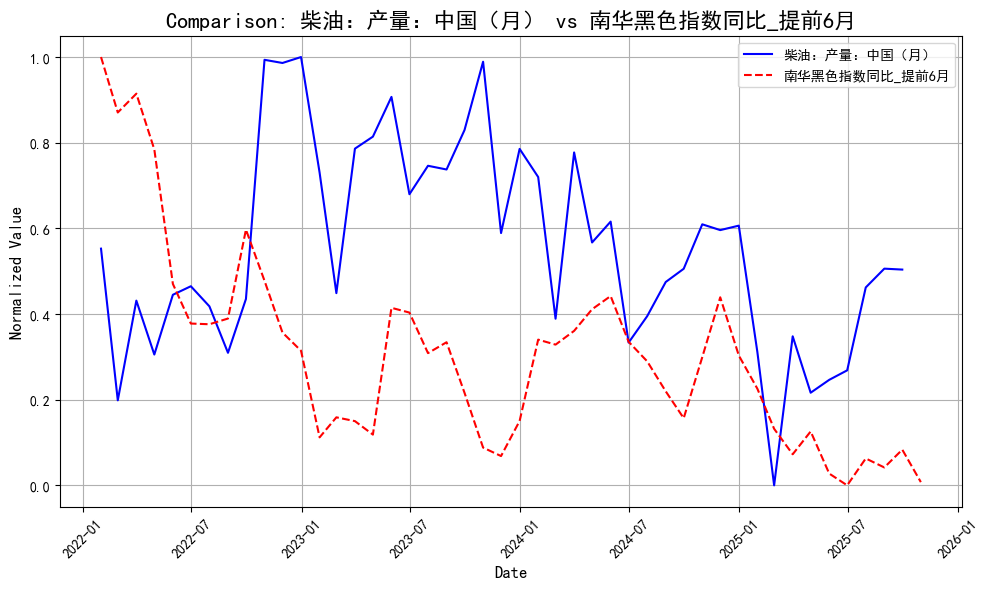

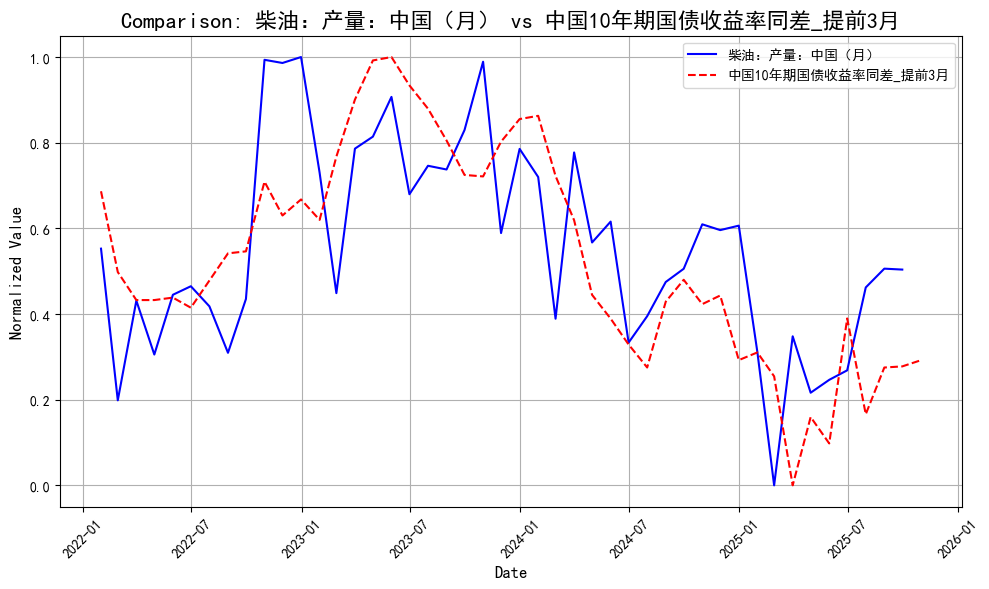

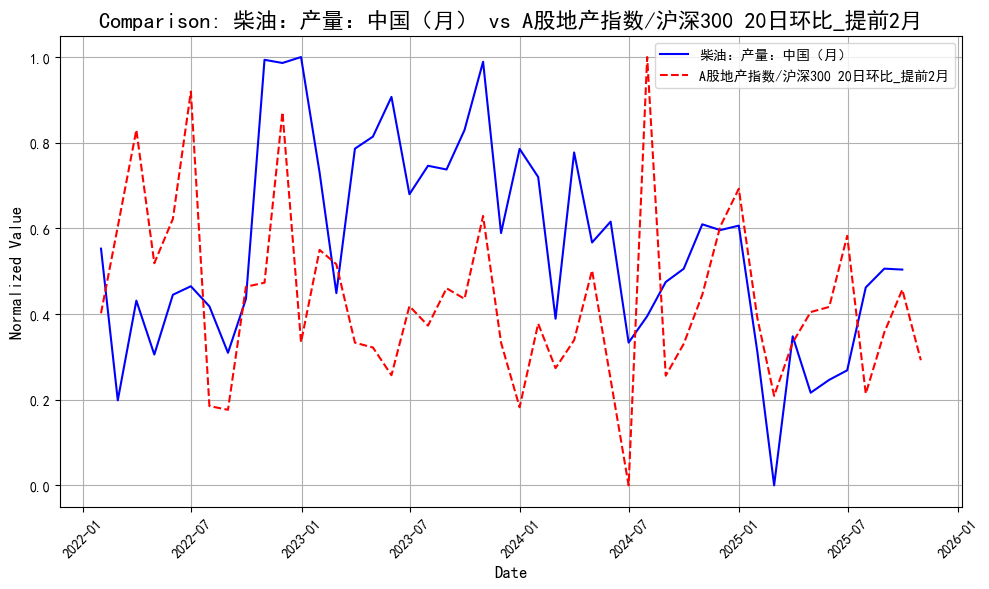

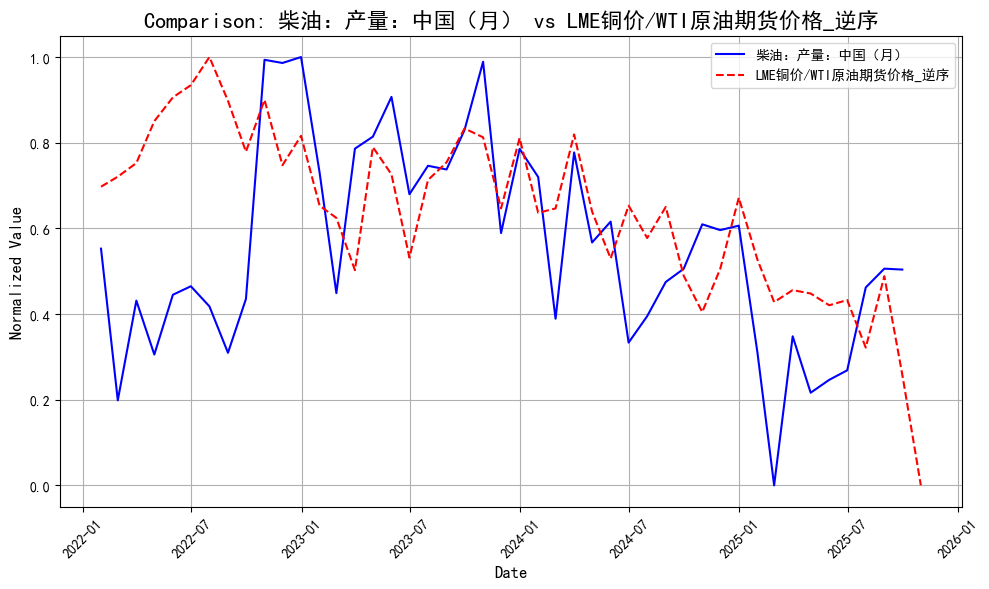

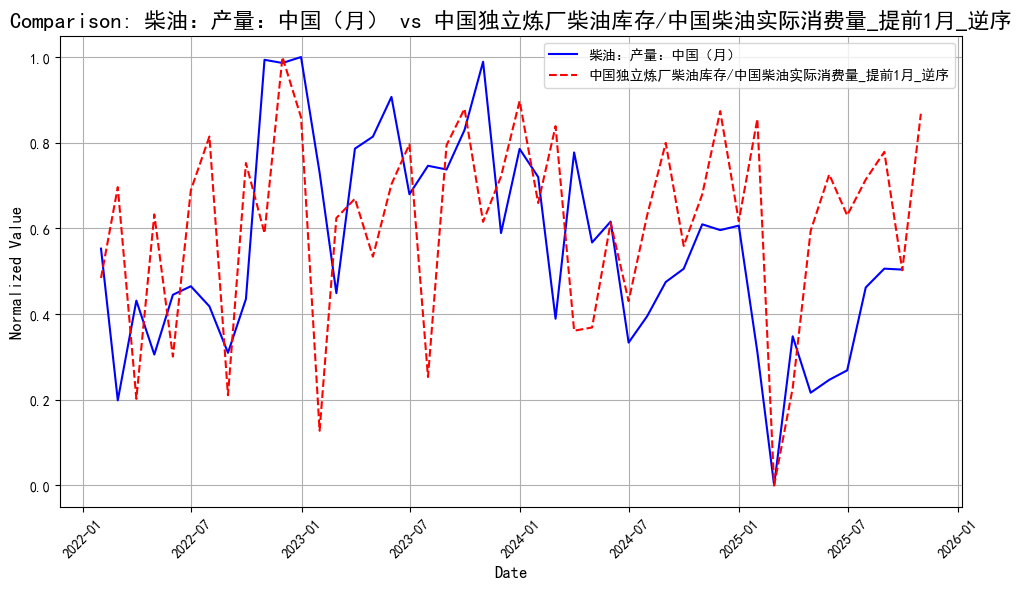

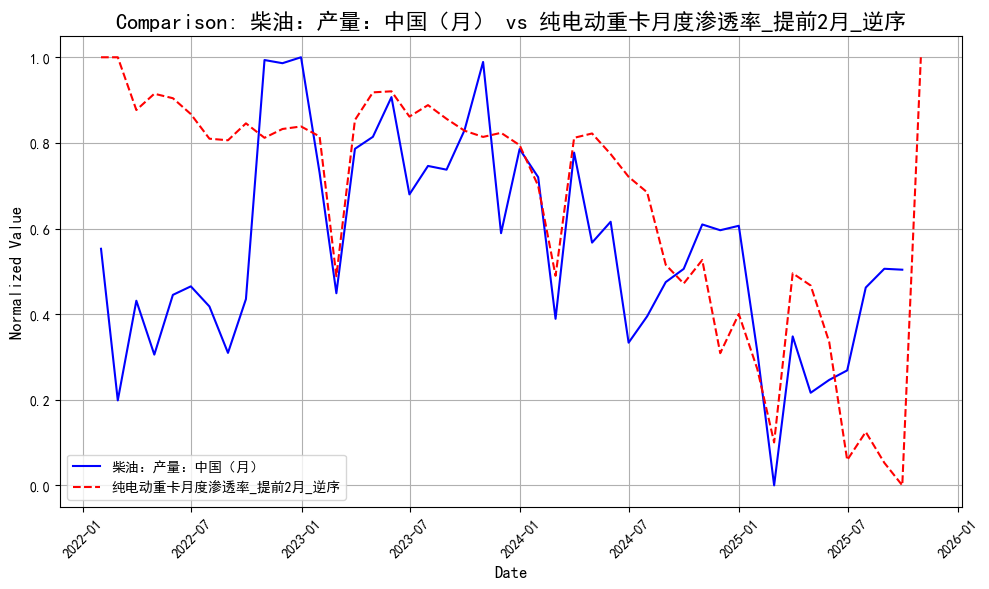

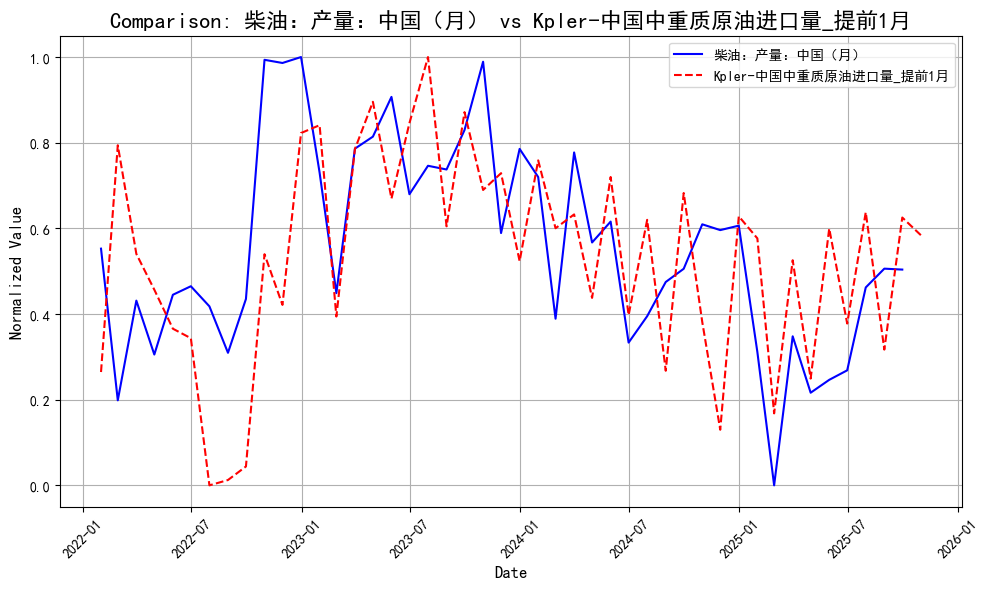

In [15]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='柴油：产量：中国（月）', 
    compare_cols=[
        '中国柴油实际消费量（周度）/4WMA同差_提前1月', 
        '中国与美国10年国债利差_提前2月', 
        '南华黑色指数同比_提前6月',
        '中国10年期国债收益率同差_提前3月',
        'A股地产指数/沪深300 20日环比_提前2月',
        'LME铜价/WTI原油期货价格_逆序',
        '中国独立炼厂柴油库存/中国柴油实际消费量_提前1月_逆序',
        '纯电动重卡月度渗透率_提前2月_逆序',
        'Kpler-中国中重质原油进口量_提前1月'
        ]
)

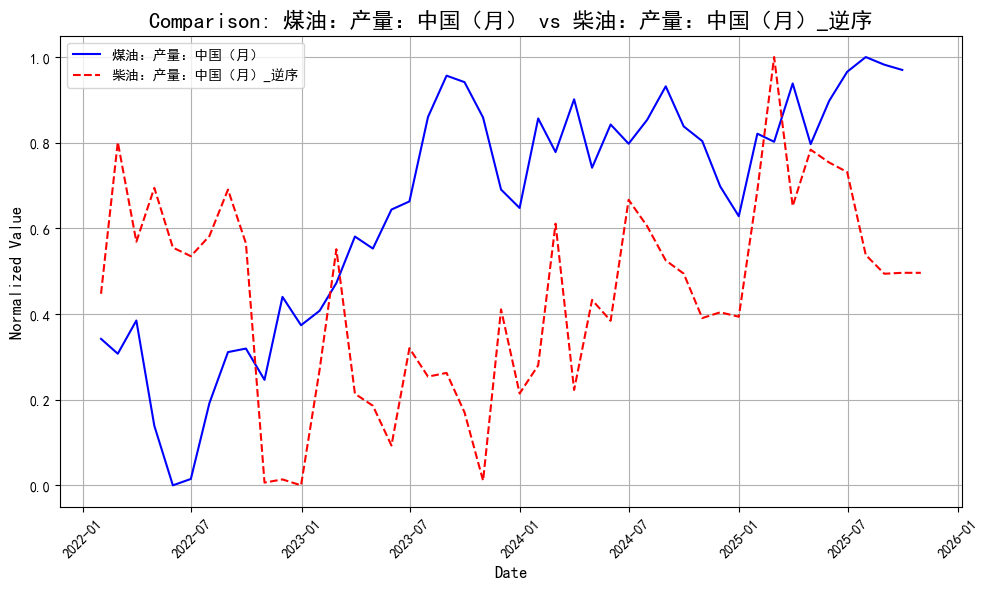

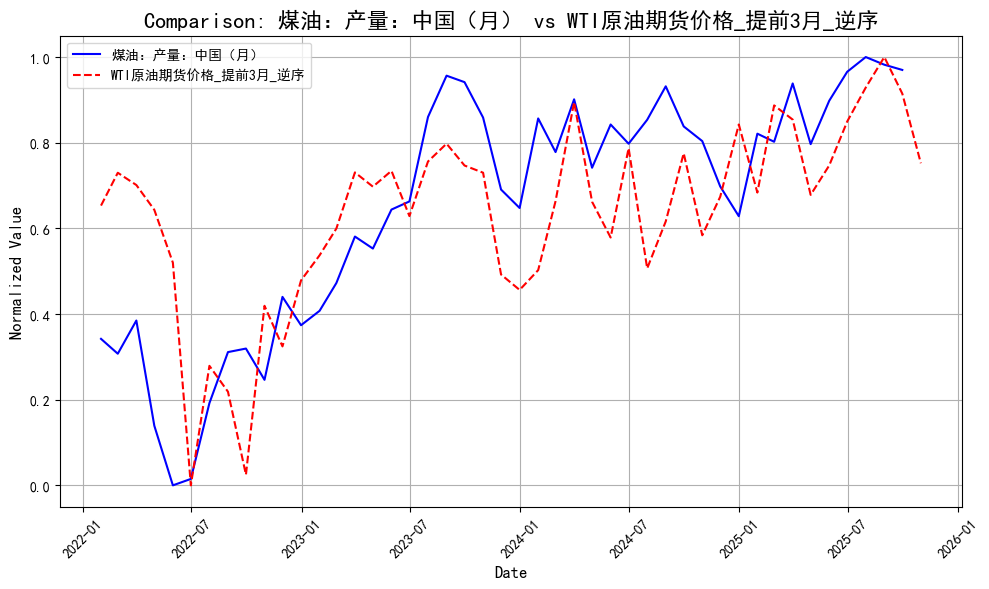

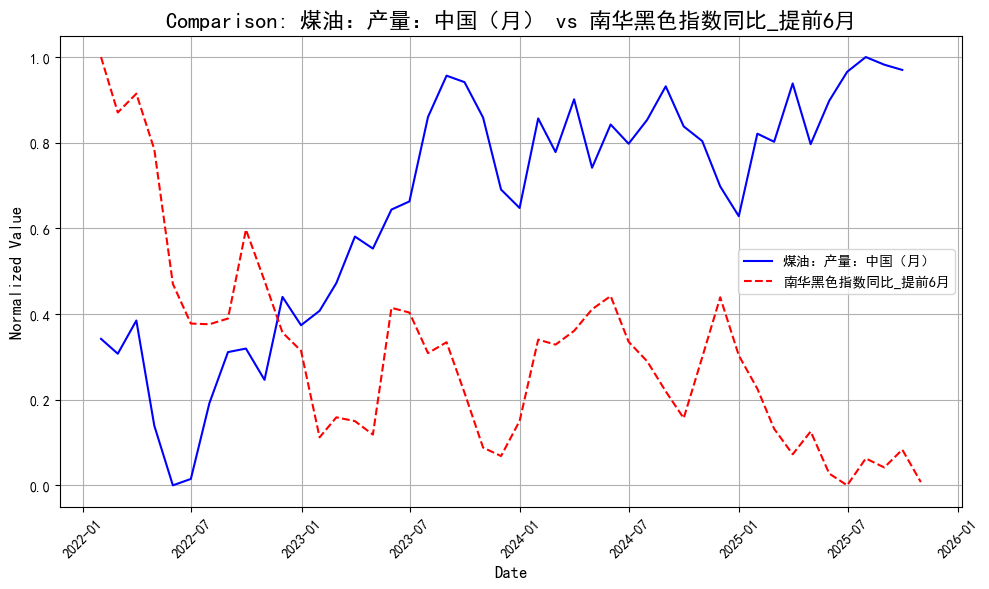

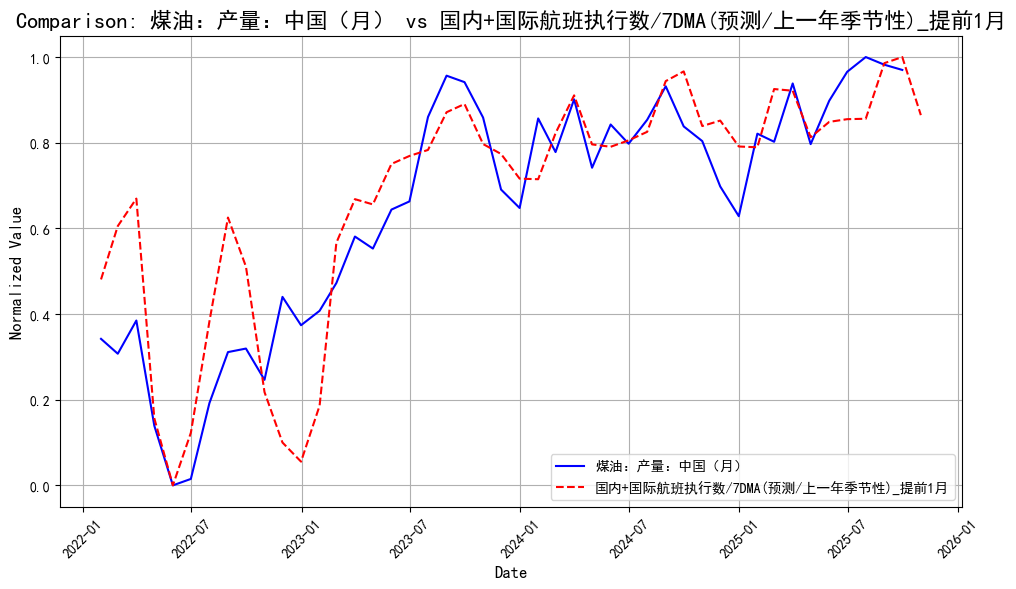

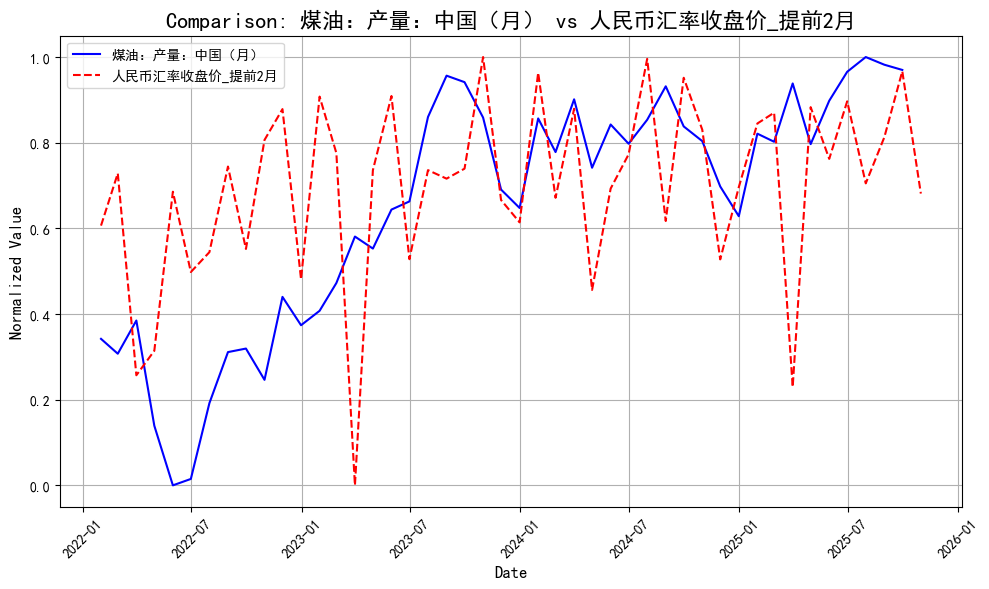

In [16]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='煤油：产量：中国（月）', 
    compare_cols=[
        '柴油：产量：中国（月）_逆序', 
        'WTI原油期货价格_提前3月_逆序', 
        '南华黑色指数同比_提前6月',
        '国内+国际航班执行数/7DMA(预测/上一年季节性)_提前1月',
        '人民币汇率收盘价_提前2月'
        ]
)

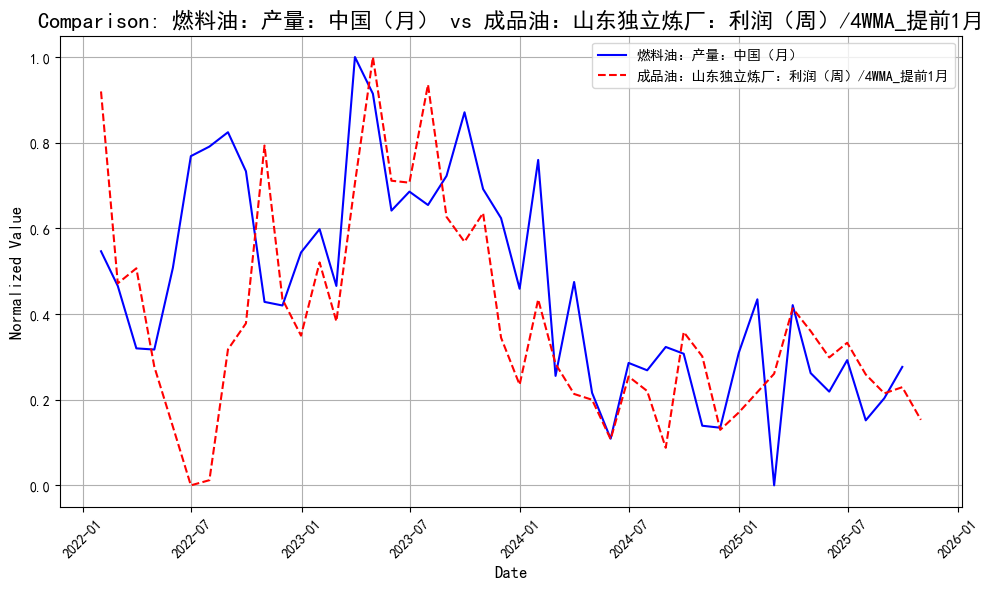

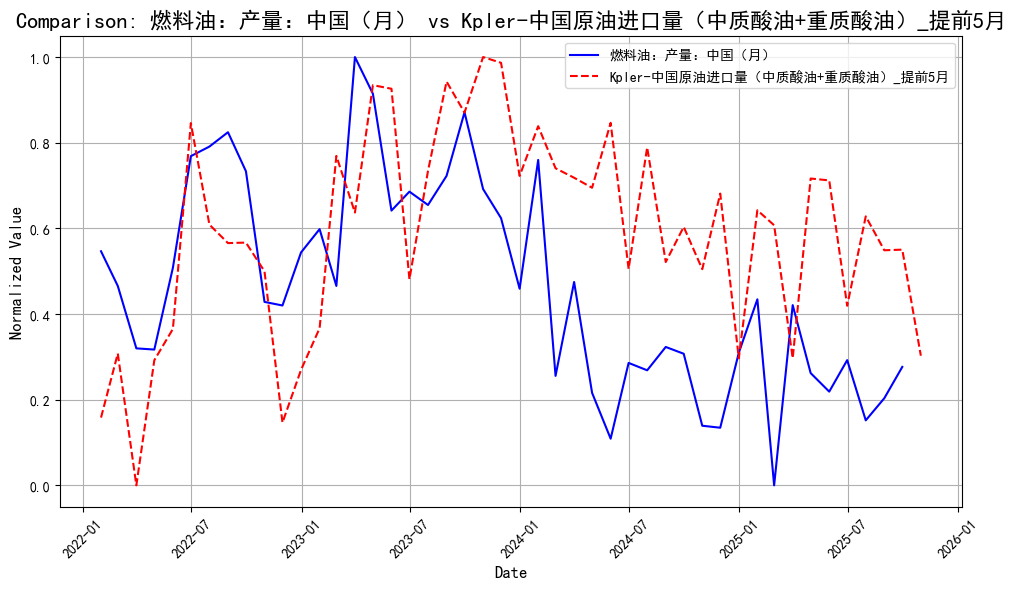

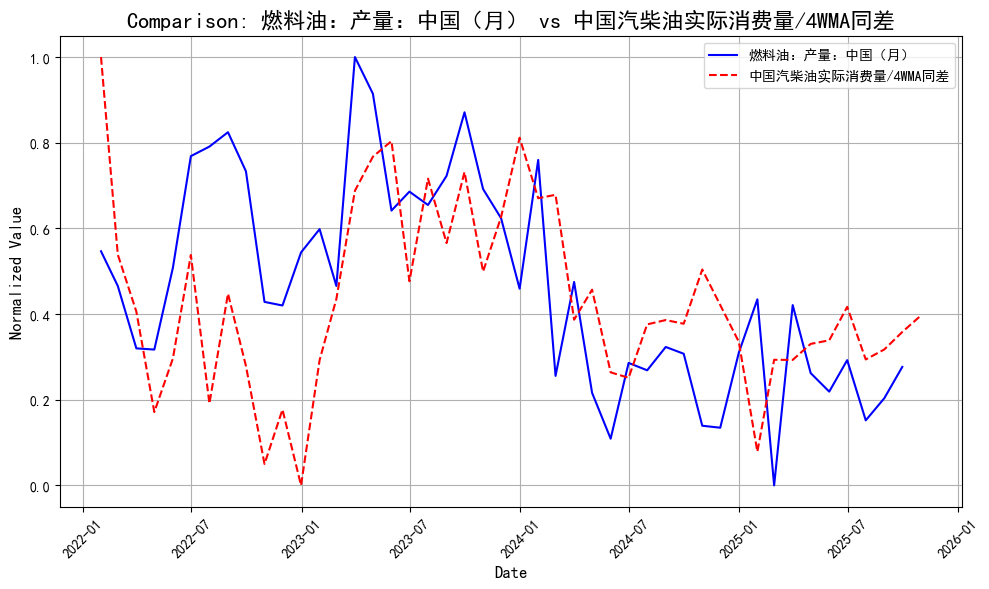

In [17]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='燃料油：产量：中国（月）', 
    compare_cols=[
        '成品油：山东独立炼厂：利润（周）/4WMA_提前1月', 
        'Kpler-中国原油进口量（中质酸油+重质酸油）_提前5月', 
        '中国汽柴油实际消费量/4WMA同差',
        ]
)

In [18]:

def train_and_predict(stage_name, feature_columns, predict_column,
                      train_data, test_data, future_data,
                      prev_preds=None):
    """
    多阶段训练预测函数
    
    参数:
    - stage_name: 阶段名，方便打印
    - feature_columns: 本阶段特征列列表（字符串）
    - predict_column: 本阶段目标列名
    - train_data, test_data, future_data: pd.DataFrame 各阶段数据集
    - prev_preds: dict，包含上阶段预测结果的列名与预测值，可以拼接作为新特征
    
    返回:
    - train_preds, test_preds, future_preds: ndarray，预测结果
    """
    print(f"\n===== {stage_name} 阶段开始 =====")
    
    # 如果有前阶段预测，拼接到数据中
    if prev_preds is not None:
        for col_name, pred_vals in prev_preds.items():
            train_data[col_name] = pred_vals['train']
            test_data[col_name] = pred_vals['test']
            future_data[col_name] = pred_vals['future']

        # 把这些预测特征加入feature_columns
        feature_columns = feature_columns + list(prev_preds.keys())
    
    # 提取X,y
    X_train = train_data[feature_columns]
    y_train = train_data[predict_column]
    
    X_test = test_data[feature_columns]
    y_test = test_data[predict_column]
    
    # 去掉 NaN 和无穷
    train_mask = y_train.notnull() & np.isfinite(y_train)
    X_train = X_train[train_mask]
    y_train = y_train[train_mask]

    test_mask = y_test.notnull() & np.isfinite(y_test)
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]


    X_future = future_data[feature_columns]
    
    # 标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_future_scaled = scaler.transform(X_future)
    
    # DMatrix
    train_dmatrix = xgb.DMatrix(X_train_scaled, label=y_train)
    test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
    future_dmatrix = xgb.DMatrix(X_future_scaled)
    
    # 样本权重 - 简化版使用Huber思想
    residuals = np.abs(y_train - y_train.mean())
    delta = np.percentile(residuals, 90)
    sample_weights = np.where(residuals <= delta, 1.0, delta / residuals)
    train_dmatrix.set_weight(sample_weights)
    
    # XGBoost参数（你给的）
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.03,
        'max_depth': 9,
        'min_child_weight': 1,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'gamma': 0.4,
        'reg_alpha': 0.4,
        'reg_lambda': 1,
        'eval_metric': 'rmse',
        'seed': 42,
        'tree_method': 'auto'
    }
    
    num_boost_round = 1000
    
    evals_result = {}
    
    model = xgb.train(
        params,
        train_dmatrix,
        num_boost_round,
        evals=[(test_dmatrix, 'eval'), (train_dmatrix, 'train')],
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=500
    )
    
    # 预测
    train_preds = model.predict(train_dmatrix)
    test_preds = model.predict(test_dmatrix)
    future_preds = model.predict(future_dmatrix)
    
    # 打印指标
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    print(f"{stage_name} 训练集 MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
    print(f"{stage_name} 测试集 MSE: {test_mse:.4f}, R²: {test_r2:.4f}")
    
    # 把预测值存回dataframe，方便后续阶段使用
    train_data.loc[:, f'{predict_column}_预测值'] = train_preds
    test_data.loc[:, f'{predict_column}_预测值'] = test_preds
    future_data.loc[:, f'{predict_column}_预测值'] = future_preds
    
    # 返回预测结果，方便下一阶段用作特征
    return {
        f'{predict_column}_预测值': {
            'train': train_preds,
            'test': test_preds,
            'future': future_preds
        }
    }



In [19]:


############################################
# 假设你的数据预处理已经完成，划分了 train_data, test_data, future_data
# 每个dataframe包含所有你需要的特征和目标列
############################################
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 3  # 你自己设定测试集长度
test_data = train_data[-test_period:].copy()
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()
# 第1阶段：柴油预测
diesel_features = [
    '中国柴油实际消费量（周度）/4WMA同差_提前1月', 
    '中国与美国10年国债利差_提前2月', 
    '南华黑色指数同比_提前6月',
    '中国10年期国债收益率同差_提前3月',
    'A股地产指数/沪深300 20日环比_提前2月',
    'LME铜价/WTI原油期货价格_逆序',
    '中国独立炼厂柴油库存/中国柴油实际消费量_提前1月_逆序',
    '纯电动重卡月度渗透率_提前2月_逆序',
    'Kpler-中国中重质原油进口量_提前1月'
]
diesel_target = '柴油：产量：中国（月）'

diesel_preds = train_and_predict(
    '柴油预测',
    diesel_features,
    diesel_target,
    train_data, test_data, future_data,
    prev_preds=None
)

# 第2阶段：汽油预测，使用柴油预测值 + 新特征
gasoline_features = [
    '中国汽油实际消费量', 
    '汽油情绪指数/4WMA_提前1月',
    'DR007利率/5DMA_提前1月',
    '山东汽油裂解差-（烷基化汽油：市场价：山东（日）-汽油：国六：92#：市场价：山东（日））_提前2月',
    '中国新能源车渗透率同差_提前2月_逆序',
    'WTI原油期货价格'
]
gasoline_target = '汽油：产量：中国（月）'

gasoline_preds = train_and_predict(
    '汽油预测',
    gasoline_features,
    gasoline_target,
    train_data, test_data, future_data,
    prev_preds=diesel_preds
)

# 第3阶段：煤油预测，使用汽油和柴油预测 + 新特征
kerosene_features = [
    'WTI原油期货价格_提前3月_逆序',
    '南华黑色指数同比_提前6月',
    '国内+国际航班执行数/7DMA(预测/上一年季节性)_提前1月',
    '人民币汇率收盘价_提前2月'
]
kerosene_target = '煤油：产量：中国（月）'

kerosene_preds = train_and_predict(
    '煤油预测',
    kerosene_features,
    kerosene_target,
    train_data, test_data, future_data,
    prev_preds={**diesel_preds, **gasoline_preds}
)

# 第4阶段：燃料油预测，使用前三阶段预测 + 新特征
fuel_oil_features = [
    '成品油：山东独立炼厂：利润（周）/4WMA_提前1月', 
    'Kpler-中国原油进口量（中质酸油+重质酸油）_提前5月', 
    '中国汽柴油实际消费量/4WMA同差'
]
fuel_oil_target = '燃料油：产量：中国（月）'

fuel_oil_preds = train_and_predict(
    '燃料油预测',
    fuel_oil_features,
    fuel_oil_target,
    train_data, test_data, future_data,
    prev_preds={**diesel_preds, **gasoline_preds, **kerosene_preds}
)

# 第5阶段：石脑油预测，使用全部四阶段预测 + 新特征
naphtha_features = [
    '中国石油苯+PX+PP+PE月度产量（预测/主观预估）'
]
naphtha_target = '中国石脑油产量'

naphtha_preds = train_and_predict(
    '石脑油预测',
    naphtha_features,
    naphtha_target,
    train_data, test_data, future_data,
    prev_preds={**diesel_preds, **gasoline_preds, **kerosene_preds, **fuel_oil_preds}
)

print("\n所有阶段预测完成！")


===== 柴油预测 阶段开始 =====
[0]	eval-rmse:37.05932	train-rmse:126.76149


[500]	eval-rmse:147.91558	train-rmse:2.09831


[999]	eval-rmse:151.05285	train-rmse:0.47334


柴油预测 训练集 MSE: 0.2559, R²: 1.0000
柴油预测 测试集 MSE: 22816.9598, R²: -189.4995

===== 汽油预测 阶段开始 =====
[0]	eval-rmse:38.00416	train-rmse:67.28485


[500]	eval-rmse:22.40022	train-rmse:1.09533


[999]	eval-rmse:22.42606	train-rmse:0.42402


汽油预测 训练集 MSE: 0.2044, R²: 1.0000
汽油预测 测试集 MSE: 502.9282, R²: -0.3421

===== 煤油预测 阶段开始 =====
[0]	eval-rmse:119.60990	train-rmse:89.70508


[500]	eval-rmse:39.78600	train-rmse:0.69388


[999]	eval-rmse:39.79475	train-rmse:0.43808

煤油预测 训练集 MSE: 0.2264, R²: 1.0000
煤油预测 测试集 MSE: 1583.6217, R²: -81.2727

===== 燃料油预测 阶段开始 =====
[0]	eval-rmse:57.45742	train-rmse:49.11752


[500]	eval-rmse:23.49281	train-rmse:0.57610

[999]	eval-rmse:23.53135	train-rmse:0.46003

燃料油预测 训练集 MSE: 0.2472, R²: 0.9999


燃料油预测 测试集 MSE: 553.7248, R²: -3.5807

===== 石脑油预测 阶段开始 =====
[0]	eval-rmse:58.71834	train-rmse:97.27629


[500]	eval-rmse:15.79488	train-rmse:0.57981


[999]	eval-rmse:15.69423	train-rmse:0.47785


石脑油预测 训练集 MSE: 0.2351, R²: 1.0000
石脑油预测 测试集 MSE: 246.3088, R²: -0.1193

所有阶段预测完成！


In [20]:
def train_all_data_predict(stage_name, feature_columns, predict_column,
                           train_data, test_data, future_data,
                           prev_preds=None):
    print(f"\n===== {stage_name} 全量数据训练 + 未来预测 =====")
    if prev_preds is not None:
        for col_name, pred_vals in prev_preds.items():
            train_data[col_name] = pred_vals['train']
            test_data[col_name] = pred_vals['test']
            future_data[col_name] = pred_vals['future']
        feature_columns = feature_columns + list(prev_preds.keys())

    # 合并训练集和测试集，训练全部数据
    all_data = pd.concat([train_data, test_data]).reset_index(drop=True)

    X_all = all_data[feature_columns]
    y_all = all_data[predict_column]

    X_future = future_data[feature_columns]

    scaler = StandardScaler()
    X_all_scaled = scaler.fit_transform(X_all)
    X_future_scaled = scaler.transform(X_future)

    all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
    future_dmatrix = xgb.DMatrix(X_future_scaled)

    residuals_all = np.abs(y_all - y_all.mean())
    delta = np.percentile(residuals_all, 90)
    sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)
    all_data_dmatrix.set_weight(sample_weights_all)

    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.03,
        'max_depth': 9,
        'min_child_weight': 1,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'gamma': 0.4,
        'reg_alpha': 0.4,
        'reg_lambda': 1,
        'eval_metric': 'rmse',
        'seed': 42,
        'tree_method': 'auto'
    }
    num_boost_round = 1000

    model = xgb.train(
        params,
        all_data_dmatrix,
        num_boost_round,
        evals=[(all_data_dmatrix, 'train')],
        early_stopping_rounds=100,
        verbose_eval=500
    )

    y_all_pred = model.predict(all_data_dmatrix)
    y_future_pred = model.predict(future_dmatrix)

    all_mse = mean_squared_error(y_all, y_all_pred)
    all_r2 = r2_score(y_all, y_all_pred)
    print(f"{stage_name} 全部数据 MSE: {all_mse:.4f}, R²: {all_r2:.4f}")

    all_data.loc[:, f'{predict_column}_预测值_全量'] = y_all_pred
    future_data.loc[:, f'{predict_column}_预测值_全量'] = y_future_pred

    # 返回预测值，方便链式调用
    return {
        f'{predict_column}_预测值_全量': {
            'train': y_all_pred[:len(train_data)],
            'test': y_all_pred[len(train_data):],
            'future': y_future_pred
        }
    }


In [21]:
# ===========================
# 3. 链式多阶段调用

# 3.1 柴油预测
diesel_preds_all = train_all_data_predict(
    stage_name='柴油预测',
    feature_columns=diesel_features,
    predict_column=diesel_target,
    train_data=train_data,
    test_data=test_data,
    future_data=future_data,
    prev_preds=None
)

# 3.2 汽油预测，使用柴油预测结果作为新特征
gasoline_preds_all = train_all_data_predict(
    stage_name='汽油预测',
    feature_columns=gasoline_features,
    predict_column=gasoline_target,
    train_data=train_data,
    test_data=test_data,
    future_data=future_data,
    prev_preds=diesel_preds_all
)

# 3.3 煤油预测，使用汽油和柴油预测结果作为特征
# 注意kerosene_features里用到了“柴油：产量：中国（月）_预测值_全量”，它必须出现在 prev_preds 键里
kerosene_prev_preds = {}
kerosene_prev_preds.update(diesel_preds_all)
kerosene_prev_preds.update(gasoline_preds_all)

kerosene_preds_all = train_all_data_predict(
    stage_name='煤油预测',
    feature_columns=kerosene_features,
    predict_column=kerosene_target,
    train_data=train_data,
    test_data=test_data,
    future_data=future_data,
    prev_preds=kerosene_prev_preds
)

# 3.4 燃料油预测，使用汽油、柴油、煤油预测结果作为特征
fuel_oil_prev_preds = {}
fuel_oil_prev_preds.update(diesel_preds_all)
fuel_oil_prev_preds.update(gasoline_preds_all)
fuel_oil_prev_preds.update(kerosene_preds_all)

fuel_oil_preds_all = train_all_data_predict(
    stage_name='燃料油预测',
    feature_columns=fuel_oil_features,
    predict_column=fuel_oil_target,
    train_data=train_data,
    test_data=test_data,
    future_data=future_data,
    prev_preds=fuel_oil_prev_preds
)

# 3.5 石脑油预测，使用所有燃料预测结果作为特征
naphtha_prev_preds = {}
naphtha_prev_preds.update(diesel_preds_all)
naphtha_prev_preds.update(gasoline_preds_all)
naphtha_prev_preds.update(kerosene_preds_all)
naphtha_prev_preds.update(fuel_oil_preds_all)

naphtha_preds_all = train_all_data_predict(
    stage_name='石脑油预测',
    feature_columns=naphtha_features,
    predict_column=naphtha_target,
    train_data=train_data,
    test_data=test_data,
    future_data=future_data,
    prev_preds=naphtha_prev_preds
)


# ===========================
# 4. 输出最终预测结果示例
print(future_data[['Date',
                   diesel_target + '_预测值_全量',
                   gasoline_target + '_预测值_全量',
                   kerosene_target + '_预测值_全量',
                   fuel_oil_target + '_预测值_全量',
                   naphtha_target + '_预测值_全量']].tail())



===== 柴油预测 全量数据训练 + 未来预测 =====
[0]	train-rmse:122.02954


[500]	train-rmse:2.12109


[999]	train-rmse:0.46175


柴油预测 全部数据 MSE: 0.2474, R²: 1.0000

===== 汽油预测 全量数据训练 + 未来预测 =====
[0]	train-rmse:65.11887


[500]	train-rmse:0.88777


[999]	train-rmse:0.43312

汽油预测 全部数据 MSE: 0.2238, R²: 1.0000



===== 煤油预测 全量数据训练 + 未来预测 =====
[0]	train-rmse:91.28790


[500]	train-rmse:0.67595

[999]	train-rmse:0.44606

煤油预测 全部数据 MSE: 0.2360, R²: 1.0000


===== 燃料油预测 全量数据训练 + 未来预测 =====
[0]	train-rmse:49.34913


[500]	train-rmse:0.56881


[999]	train-rmse:0.45779


燃料油预测 全部数据 MSE: 0.2490, R²: 0.9999


===== 石脑油预测 全量数据训练 + 未来预测 =====
[0]	train-rmse:94.99084


[500]	train-rmse:0.60990

[999]	train-rmse:0.49246

石脑油预测 全部数据 MSE: 0.2521, R²: 1.0000
         Date  柴油：产量：中国（月）_预测值_全量  汽油：产量：中国（月）_预测值_全量  煤油：产量：中国（月）_预测值_全量  \
45 2025-10-31         1744.709717         1306.439209          532.010986   

    燃料油：产量：中国（月）_预测值_全量  中国石脑油产量_预测值_全量  
45           375.500977       670.09082  



计算五种油品产量总和:
         Date  中国汽油+柴油+煤油+石脑油+燃料油产量_预测  原油：加工量：中国（月）\t_预测
45 2025-10-31              4628.751953        6187.600802


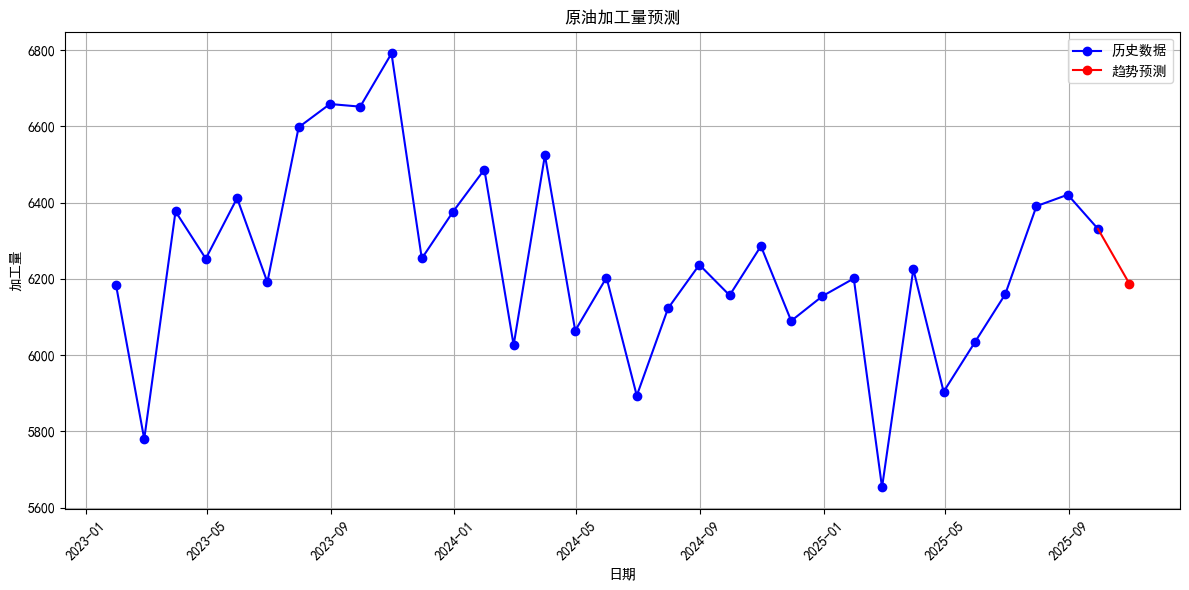

In [22]:
# 计算五种油品产量总和
future_data['中国汽油+柴油+煤油+石脑油+燃料油产量_预测'] = (
    future_data['柴油：产量：中国（月）_预测值_全量'] + 
    future_data['汽油：产量：中国（月）_预测值_全量'] +
    future_data['煤油：产量：中国（月）_预测值_全量'] +
    future_data['燃料油：产量：中国（月）_预测值_全量'] +
    future_data['中国石脑油产量_预测值_全量']
)

# 使用线性回归预测原油加工量

# 准备训练数据
train_test_data = pd.concat([train_data, test_data])
X = train_test_data[['中国汽油+柴油+煤油+石脑油+燃料油产量']].values
y = train_test_data['原油：加工量：中国（月）\t'].values

# 训练线性回归模型
lr_model = LinearRegression()
lr_model.fit(X, y)

# 对未来数据进行预测
future_X = future_data[['中国汽油+柴油+煤油+石脑油+燃料油产量_预测']].values
future_data['原油：加工量：中国（月）\t_预测'] = lr_model.predict(future_X)

# 显示计算结果
print("\n计算五种油品产量总和:")
print(future_data[['Date', '中国汽油+柴油+煤油+石脑油+燃料油产量_预测','原油：加工量：中国（月）\t_预测']].tail())

# 绘制图表展示
train_data_2023 = train_test_data[train_test_data['Date'] >= '2023-01-01']
plt.figure(figsize=(12, 6))

# 绘制历史数据,选取2023年1月以后的数据
plt.plot(train_data_2023['Date'], train_data_2023['原油：加工量：中国（月）\t'], 'b-', label='历史数据', marker='o')

# 连接历史数据最后一个点和预测数据第一个点
plt.plot([train_test_data['Date'].iloc[-1], future_data['Date'].iloc[0]], 
         [train_test_data['原油：加工量：中国（月）\t'].iloc[-1], future_data['原油：加工量：中国（月）\t_预测'].iloc[0]], 'r-')

# 绘制预测数据
plt.plot(future_data['Date'], future_data['原油：加工量：中国（月）\t_预测'], 'r-', label='趋势预测', marker='o')

plt.title('原油加工量预测')
plt.xlabel('日期')
plt.ylabel('加工量')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


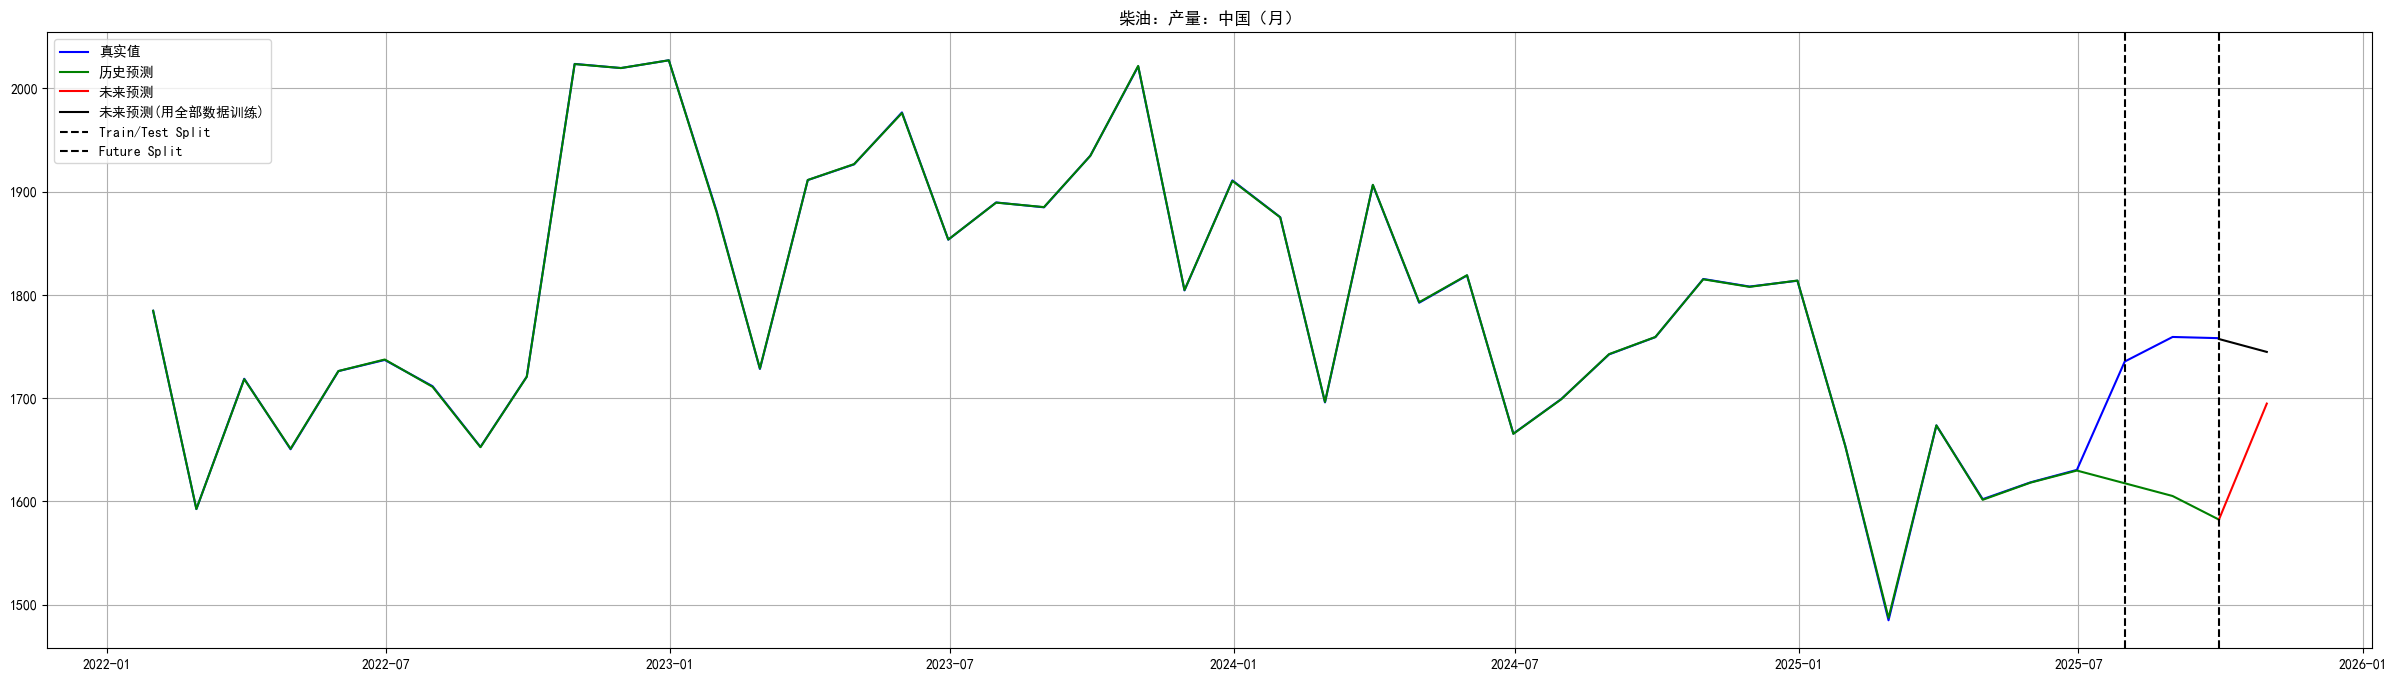

In [23]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
#future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 合并数据集以创建连续的线条
all_data = pd.concat([train_data, test_data, future_data])

# 绘制真实值
plt.plot(all_data['Date'], all_data['柴油：产量：中国（月）'], label='真实值', color='blue')

# 分别绘制各阶段的预测值
# 训练集和测试集的预测值
train_test_data = pd.concat([
    all_data[all_data.index.isin(train_data.index)],
    all_data[all_data.index.isin(test_data.index)]
])
plt.plot(train_test_data['Date'], train_test_data['柴油：产量：中国（月）_预测值'], label='历史预测', color='green')

# 获取未来数据的掩码
future_mask = all_data.index.isin(future_data.index)

# 获取最后一个历史数据点
last_historical = train_test_data.iloc[-1]

# 创建包含最后一个历史点和未来预测的数据
future_with_last = pd.concat([
    pd.DataFrame([last_historical]),
    all_data[future_mask]
])

# 绘制包含连接点的预测线
plt.plot(future_with_last['Date'], future_with_last['柴油：产量：中国（月）_预测值'], label='未来预测', color='red')
plt.plot(future_with_last['Date'], future_with_last['柴油：产量：中国（月）_预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('柴油：产量：中国（月）')
plt.legend()
plt.grid(True)
plt.show()

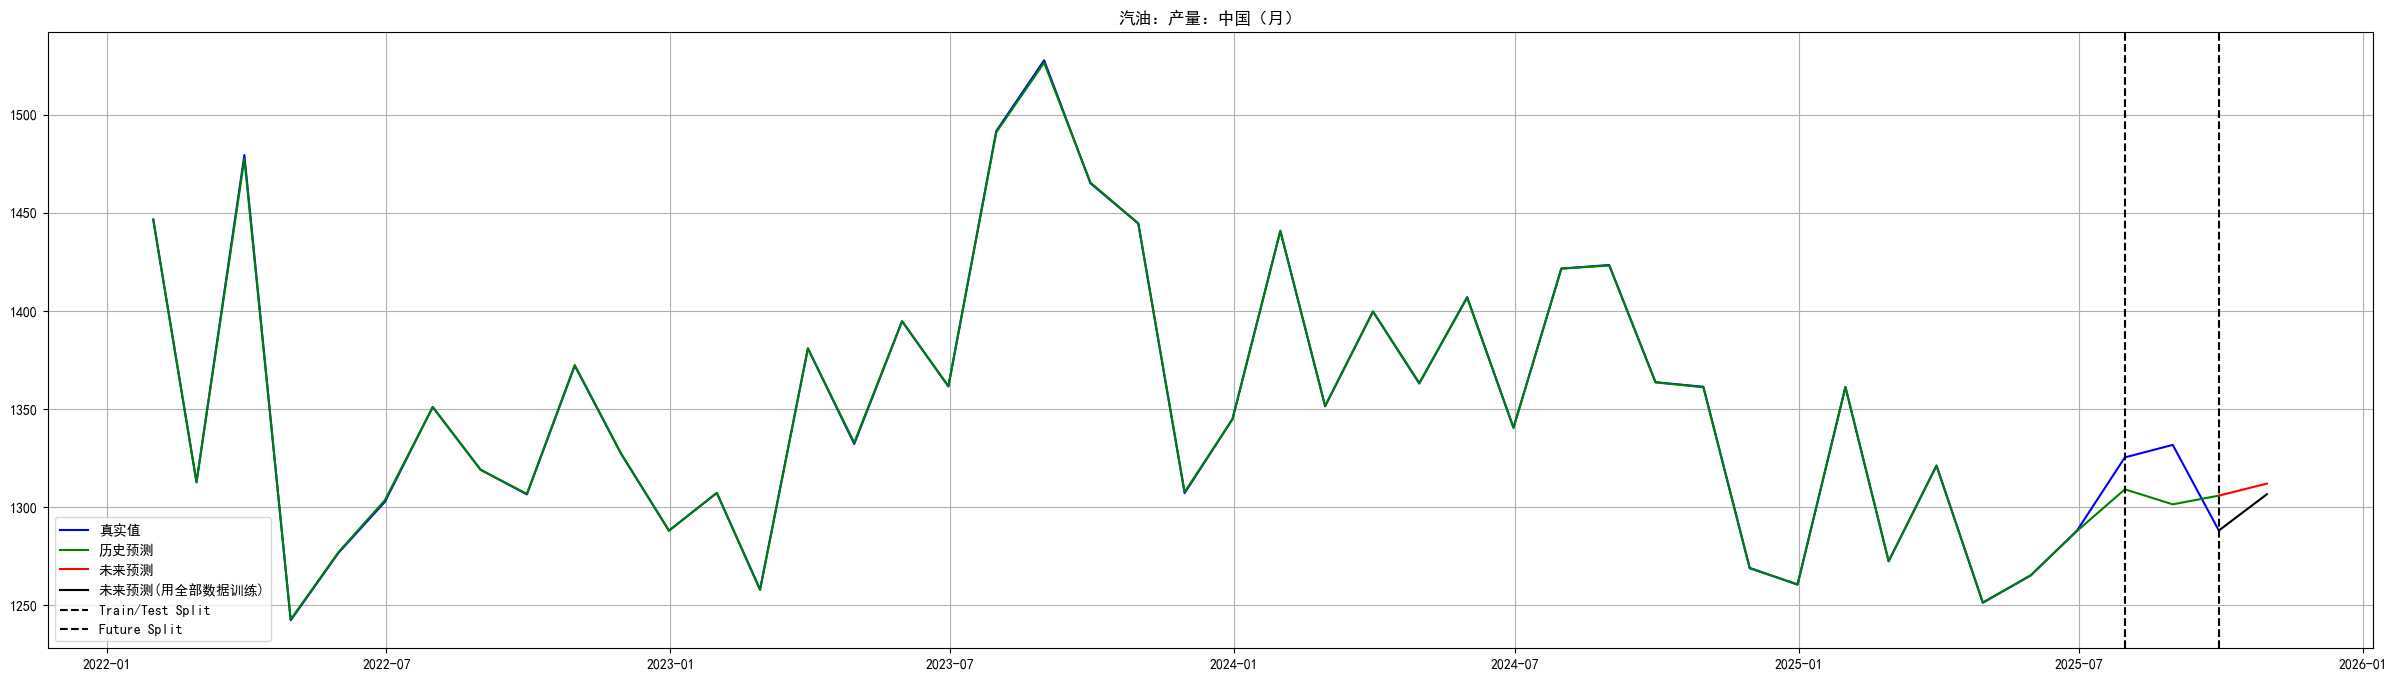

In [24]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
#future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 合并数据集以创建连续的线条
all_data = pd.concat([train_data, test_data, future_data])

# 绘制真实值
plt.plot(all_data['Date'], all_data['汽油：产量：中国（月）'], label='真实值', color='blue')

# 分别绘制各阶段的预测值
# 训练集和测试集的预测值
train_test_data = pd.concat([
    all_data[all_data.index.isin(train_data.index)],
    all_data[all_data.index.isin(test_data.index)]
])
plt.plot(train_test_data['Date'], train_test_data['汽油：产量：中国（月）_预测值'], label='历史预测', color='green')

# 获取未来数据的掩码
future_mask = all_data.index.isin(future_data.index)

# 获取最后一个历史数据点
last_historical = train_test_data.iloc[-1]

# 创建包含最后一个历史点和未来预测的数据
future_with_last = pd.concat([
    pd.DataFrame([last_historical]),
    all_data[future_mask]
])

# 绘制包含连接点的预测线
plt.plot(future_with_last['Date'], future_with_last['汽油：产量：中国（月）_预测值'], label='未来预测', color='red')
plt.plot(future_with_last['Date'], future_with_last['汽油：产量：中国（月）_预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('汽油：产量：中国（月）')
plt.legend()
plt.grid(True)
plt.show()

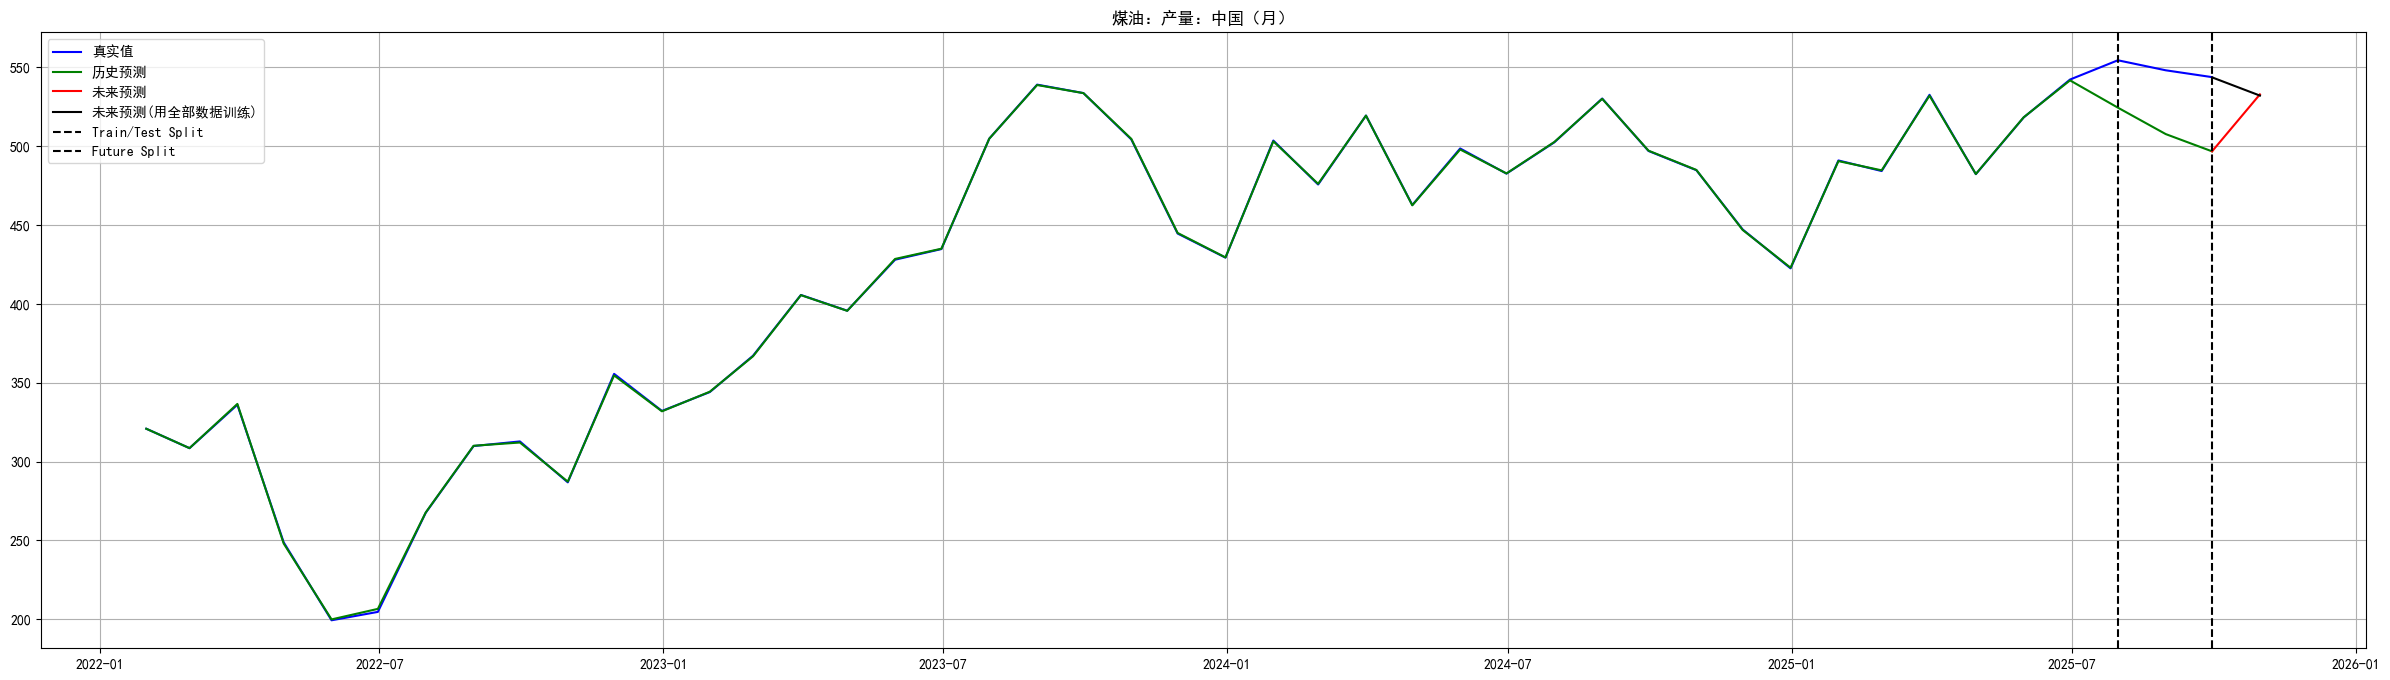

In [25]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
#future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 合并数据集以创建连续的线条
all_data = pd.concat([train_data, test_data, future_data])

# 绘制真实值
plt.plot(all_data['Date'], all_data['煤油：产量：中国（月）'], label='真实值', color='blue')

# 分别绘制各阶段的预测值
# 训练集和测试集的预测值
train_test_data = pd.concat([
    all_data[all_data.index.isin(train_data.index)],
    all_data[all_data.index.isin(test_data.index)]
])
plt.plot(train_test_data['Date'], train_test_data['煤油：产量：中国（月）_预测值'], label='历史预测', color='green')

# 获取未来数据的掩码
future_mask = all_data.index.isin(future_data.index)

# 获取最后一个历史数据点
last_historical = train_test_data.iloc[-1]

# 创建包含最后一个历史点和未来预测的数据
future_with_last = pd.concat([
    pd.DataFrame([last_historical]),
    all_data[future_mask]
])

# 绘制包含连接点的预测线
plt.plot(future_with_last['Date'], future_with_last['煤油：产量：中国（月）_预测值'], label='未来预测', color='red')
plt.plot(future_with_last['Date'], future_with_last['煤油：产量：中国（月）_预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('煤油：产量：中国（月）')
plt.legend()
plt.grid(True)
plt.show()

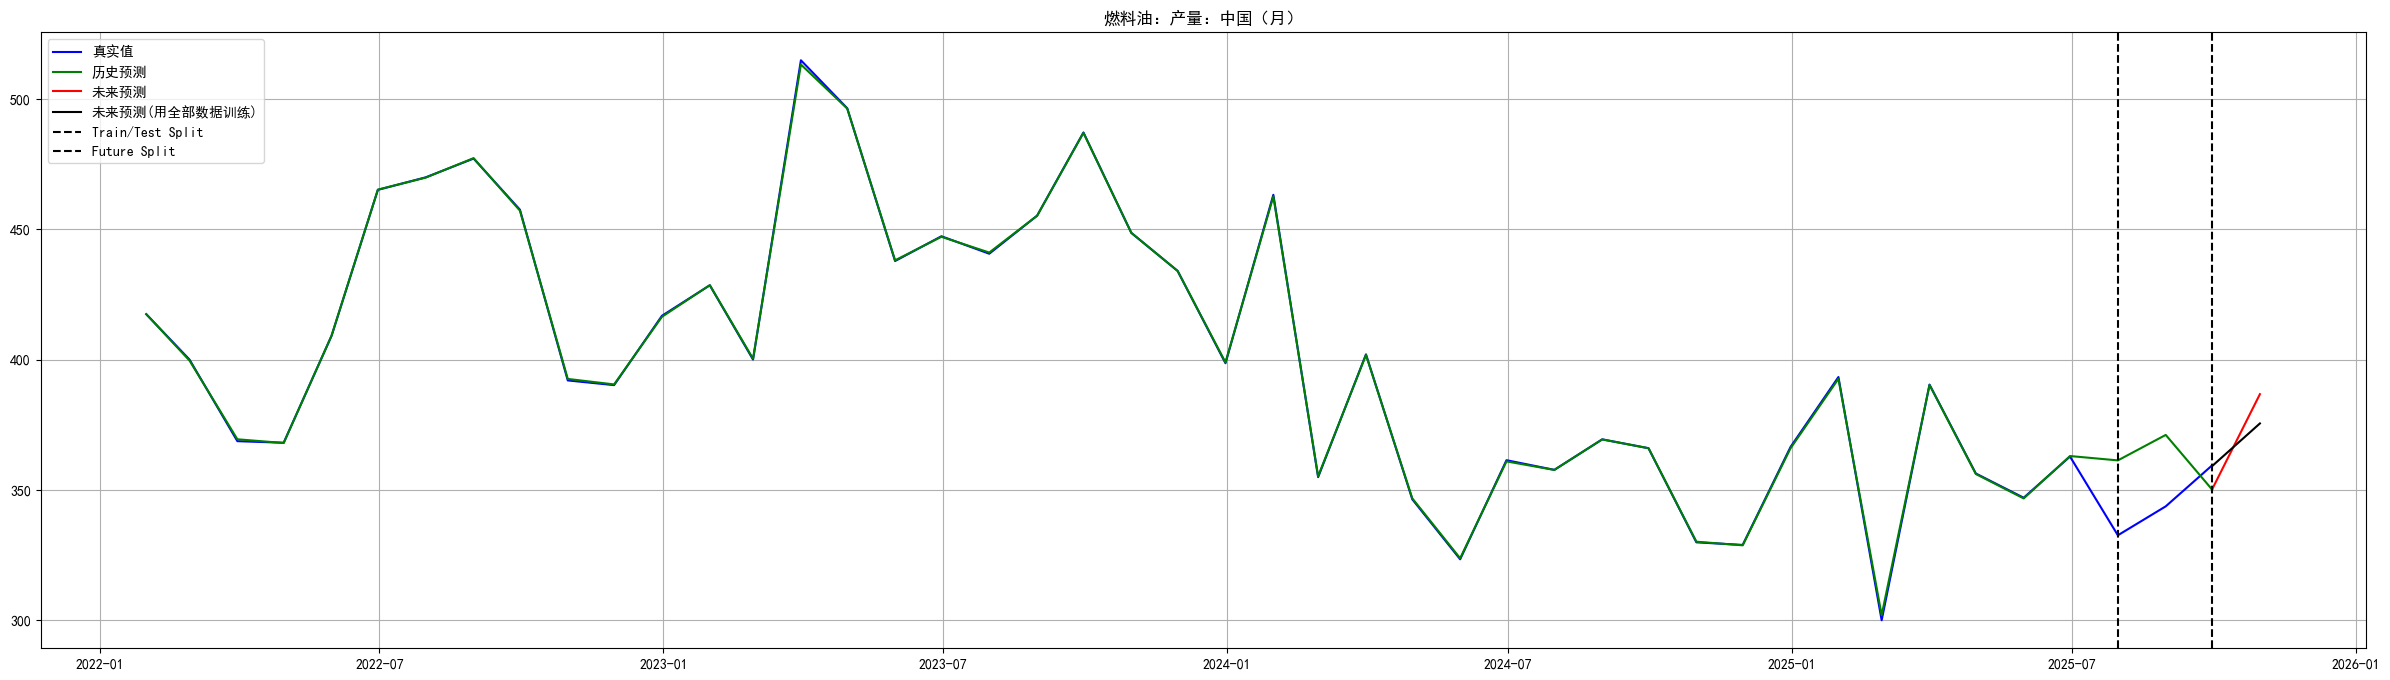

In [26]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
#future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 合并数据集以创建连续的线条
all_data = pd.concat([train_data, test_data, future_data])

# 绘制真实值
plt.plot(all_data['Date'], all_data['燃料油：产量：中国（月）'], label='真实值', color='blue')

# 分别绘制各阶段的预测值
# 训练集和测试集的预测值
train_test_data = pd.concat([
    all_data[all_data.index.isin(train_data.index)],
    all_data[all_data.index.isin(test_data.index)]
])
plt.plot(train_test_data['Date'], train_test_data['燃料油：产量：中国（月）_预测值'], label='历史预测', color='green')

# 获取未来数据的掩码
future_mask = all_data.index.isin(future_data.index)

# 获取最后一个历史数据点
last_historical = train_test_data.iloc[-1]

# 创建包含最后一个历史点和未来预测的数据
future_with_last = pd.concat([
    pd.DataFrame([last_historical]),
    all_data[future_mask]
])

# 绘制包含连接点的预测线
plt.plot(future_with_last['Date'], future_with_last['燃料油：产量：中国（月）_预测值'], label='未来预测', color='red')
plt.plot(future_with_last['Date'], future_with_last['燃料油：产量：中国（月）_预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('燃料油：产量：中国（月）')
plt.legend()
plt.grid(True)
plt.show()

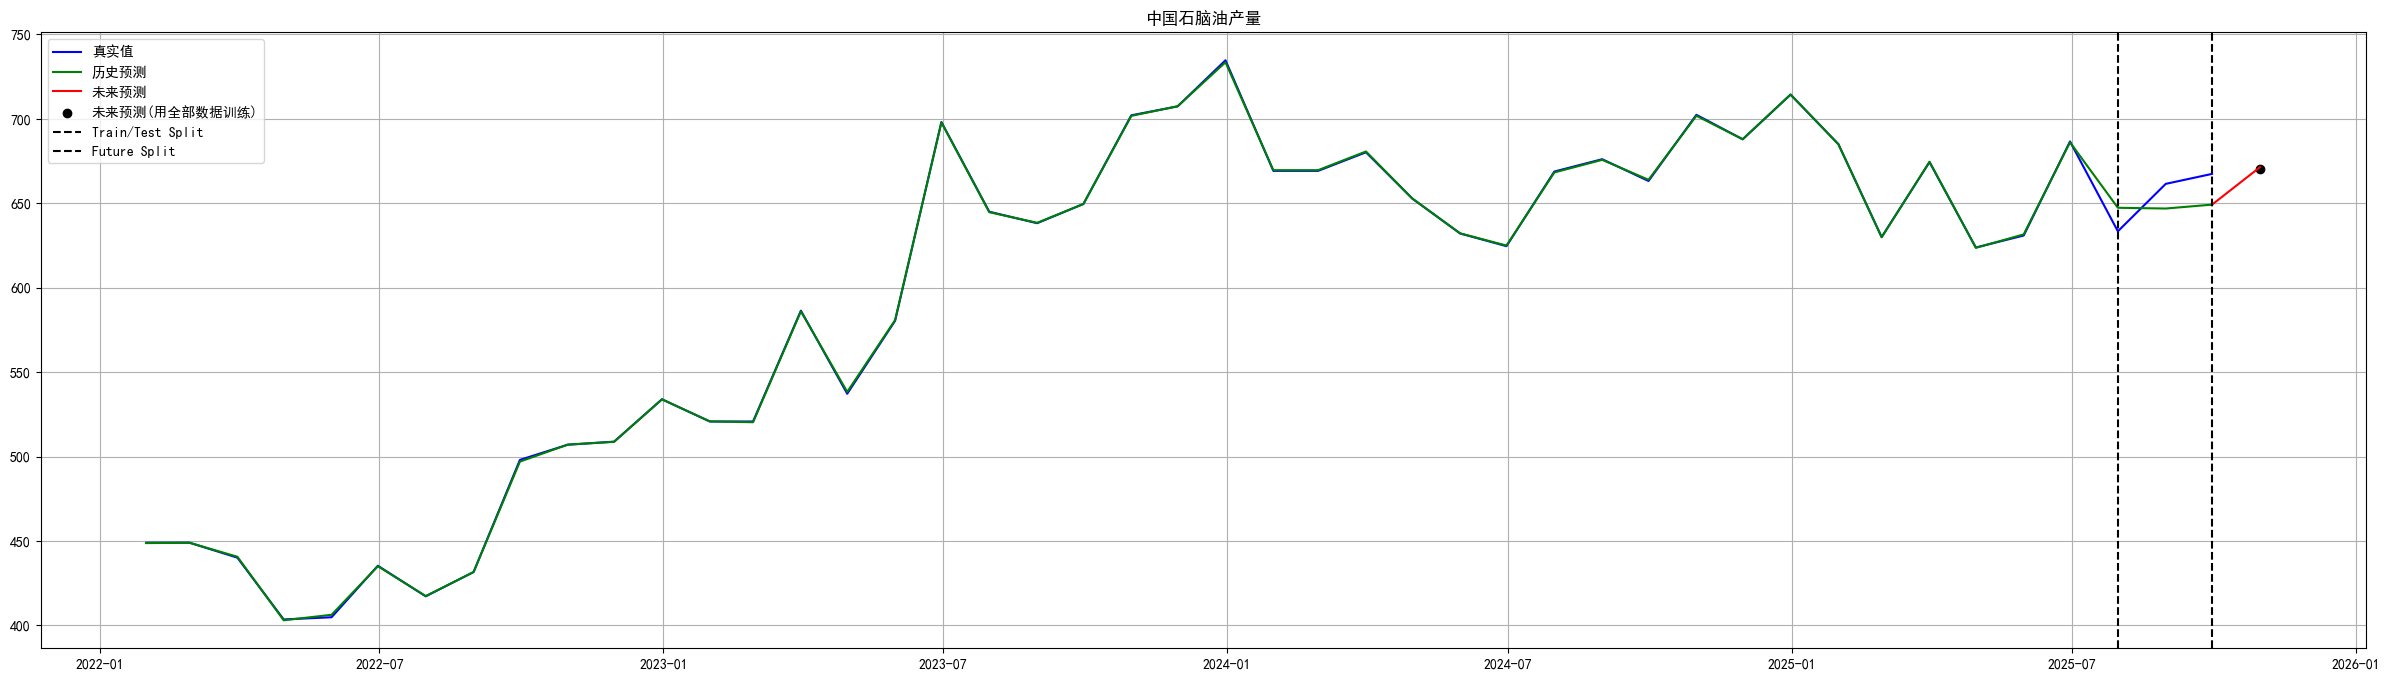

In [27]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
#future_data = plot_predictions(y_test, future_data, col=True, label=True)
# 合并数据集以创建连续的线条
all_data = pd.concat([train_data, test_data, future_data])

# 绘制真实值
plt.plot(all_data['Date'], all_data['中国石脑油产量'], label='真实值', color='blue')

# 分别绘制各阶段的预测值
# 训练集和测试集的预测值
train_test_data = pd.concat([
    all_data[all_data.index.isin(train_data.index)],
    all_data[all_data.index.isin(test_data.index)]
])
plt.plot(train_test_data['Date'], train_test_data['中国石脑油产量_预测值'], label='历史预测', color='green')

# 获取未来数据的掩码
future_mask = all_data.index.isin(future_data.index)

# 获取最后一个历史数据点
last_historical = train_test_data.iloc[-1]

# 创建包含最后一个历史点和未来预测的数据
future_with_last = pd.concat([
    pd.DataFrame([last_historical]),
    all_data[future_mask]
])

# 绘制包含连接点的预测线
plt.plot(future_with_last['Date'], future_with_last['中国石脑油产量_预测值'], label='未来预测', color='red')
plt.scatter(future_with_last['Date'], future_with_last['中国石脑油产量_预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('中国石脑油产量')
plt.legend()
plt.grid(True)
plt.show()

---

In [28]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''
############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': train_test_data['Date'],
    '真实值': train_test_data['中国汽油+柴油+煤油+石脑油+燃料油产量'],
    '柴油产量': train_test_data['柴油：产量：中国（月）'],
    '汽油产量': train_test_data['汽油：产量：中国（月）'],
    '煤油产量': train_test_data['煤油：产量：中国（月）'],
    '燃料油产量': train_test_data['燃料油：产量：中国（月）'],
    '石脑油产量': train_test_data['中国石脑油产量'],
    '原油加工量': train_test_data['原油：加工量：中国（月）\t']
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]

# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['中国汽油+柴油+煤油+石脑油+燃料油产量_预测'],
    '柴油产量预测': future_data['柴油：产量：中国（月）_预测值_全量'],
    '汽油产量预测': future_data['汽油：产量：中国（月）_预测值_全量'], 
    '煤油产量预测': future_data['煤油：产量：中国（月）_预测值_全量'],
    '燃料油产量预测': future_data['燃料油：产量：中国（月）_预测值_全量'],
    '石脑油产量预测': future_data['中国石脑油产量_预测值'],
    '原油加工量预测': future_data['原油：加工量：中国（月）\t_预测']
})

# 分别保存各个产品数据
# 总产量
merged_total = pd.merge(
    historical_actual_daily[['Date','真实值']], 
    future_pred_daily[['Date','预测值']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_total['Date'] = merged_total['Date'].dt.strftime('%Y/%m/%d')
merged_total.to_excel('eta/中国汽油柴油煤油石脑油燃料油总产量_合并数据.xlsx', index=False, float_format='%.1f')

# 柴油
merged_diesel = pd.merge(
    historical_actual_daily[['Date','柴油产量']], 
    future_pred_daily[['Date','柴油产量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_diesel['Date'] = merged_diesel['Date'].dt.strftime('%Y/%m/%d')
merged_diesel.to_excel('eta/中国柴油产量_合并数据.xlsx', index=False, float_format='%.1f')

# 汽油
merged_gasoline = pd.merge(
    historical_actual_daily[['Date','汽油产量']], 
    future_pred_daily[['Date','汽油产量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_gasoline['Date'] = merged_gasoline['Date'].dt.strftime('%Y/%m/%d')
merged_gasoline.to_excel('eta/中国汽油产量_合并数据.xlsx', index=False, float_format='%.1f')

# 煤油
merged_kerosene = pd.merge(
    historical_actual_daily[['Date','煤油产量']], 
    future_pred_daily[['Date','煤油产量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_kerosene['Date'] = merged_kerosene['Date'].dt.strftime('%Y/%m/%d')
merged_kerosene.to_excel('eta/中国煤油产量_合并数据.xlsx', index=False, float_format='%.1f')

# 燃料油
merged_fuel = pd.merge(
    historical_actual_daily[['Date','燃料油产量']], 
    future_pred_daily[['Date','燃料油产量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_fuel['Date'] = merged_fuel['Date'].dt.strftime('%Y/%m/%d')
merged_fuel.to_excel('eta/中国燃料油产量_合并数据.xlsx', index=False, float_format='%.1f')

# 石脑油
merged_naphtha = pd.merge(
    historical_actual_daily[['Date','石脑油产量']], 
    future_pred_daily[['Date','石脑油产量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_naphtha['Date'] = merged_naphtha['Date'].dt.strftime('%Y/%m/%d')
merged_naphtha.to_excel('eta/中国石脑油产量_合并数据.xlsx', index=False, float_format='%.1f')

# 原油加工量
merged_crude = pd.merge(
    historical_actual_daily[['Date','原油加工量']], 
    future_pred_daily[['Date','原油加工量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_crude['Date'] = merged_crude['Date'].dt.strftime('%Y/%m/%d')
merged_crude.to_excel('eta/中国原油加工量_合并数据.xlsx', index=False, float_format='%.1f')



In [29]:
############ 月度 数据 ############
# 创建月度数据框
historical_actual_monthly = pd.DataFrame({
    'Date': train_test_data['Date'],
    '真实值': train_test_data['中国汽油+柴油+煤油+石脑油+燃料油产量'],
    '柴油产量': train_test_data['柴油：产量：中国（月）'],
    '汽油产量': train_test_data['汽油：产量：中国（月）'],
    '煤油产量': train_test_data['煤油：产量：中国（月）'],
    '燃料油产量': train_test_data['燃料油：产量：中国（月）'],
    '石脑油产量': train_test_data['中国石脑油产量'],
    '原油加工量': train_test_data['原油：加工量：中国（月）\t']
})

# 只保留2023年之后的数据
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]

# 创建预测数据框
future_pred_monthly = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['中国汽油+柴油+煤油+石脑油+燃料油产量_预测'],
    '柴油产量预测': future_data['柴油：产量：中国（月）_预测值_全量'],
    '汽油产量预测': future_data['汽油：产量：中国（月）_预测值_全量'],
    '煤油产量预测': future_data['煤油：产量：中国（月）_预测值_全量'],
    '燃料油产量预测': future_data['燃料油：产量：中国（月）_预测值_全量'],
    '石脑油产量预测': future_data['中国石脑油产量_预测值'],
    '原油加工量预测': future_data['原油：加工量：中国（月）\t_预测']
})

# 分别保存各个产品月度数据
# 总产量
merged_total_monthly = pd.merge(
    historical_actual_monthly[['Date','真实值']], 
    future_pred_monthly[['Date','预测值']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_total_monthly['Date'] = merged_total_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_total_monthly.to_excel('eta/中国汽油柴油煤油石脑油燃料油总产量_月度数据.xlsx', index=False, float_format='%.1f')

# 柴油
merged_diesel_monthly = pd.merge(
    historical_actual_monthly[['Date','柴油产量']], 
    future_pred_monthly[['Date','柴油产量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_diesel_monthly['Date'] = merged_diesel_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_diesel_monthly.to_excel('eta/中国柴油产量_月度数据.xlsx', index=False, float_format='%.1f')

# 汽油
merged_gasoline_monthly = pd.merge(
    historical_actual_monthly[['Date','汽油产量']], 
    future_pred_monthly[['Date','汽油产量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_gasoline_monthly['Date'] = merged_gasoline_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_gasoline_monthly.to_excel('eta/中国汽油产量_月度数据.xlsx', index=False, float_format='%.1f')

# 煤油
merged_kerosene_monthly = pd.merge(
    historical_actual_monthly[['Date','煤油产量']], 
    future_pred_monthly[['Date','煤油产量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_kerosene_monthly['Date'] = merged_kerosene_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_kerosene_monthly.to_excel('eta/中国煤油产量_月度数据.xlsx', index=False, float_format='%.1f')

# 燃料油
merged_fuel_monthly = pd.merge(
    historical_actual_monthly[['Date','燃料油产量']], 
    future_pred_monthly[['Date','燃料油产量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_fuel_monthly['Date'] = merged_fuel_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_fuel_monthly.to_excel('eta/中国燃料油产量_月度数据.xlsx', index=False, float_format='%.1f')

# 石脑油
merged_naphtha_monthly = pd.merge(
    historical_actual_monthly[['Date','石脑油产量']], 
    future_pred_monthly[['Date','石脑油产量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_naphtha_monthly['Date'] = merged_naphtha_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_naphtha_monthly.to_excel('eta/中国石脑油产量_月度数据.xlsx', index=False, float_format='%.1f')

# 原油加工量
merged_crude_monthly = pd.merge(
    historical_actual_monthly[['Date','原油加工量']], 
    future_pred_monthly[['Date','原油加工量预测']], 
    on='Date', how='outer'
).sort_values('Date', ascending=False)
merged_crude_monthly['Date'] = merged_crude_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_crude_monthly.to_excel('eta/中国原油加工量_月度数据.xlsx', index=False, float_format='%.1f')

In [30]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "原油：加工量：中国（月）"

# 调用函数更新数据
success = update_excel_data(merged_total, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [31]:

from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "原油：加工量：中国（月）"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_total_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 22 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [32]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国汽油+柴油+煤油+石脑油+燃料油产量"

# 调用函数更新数据
success = update_excel_data(merged_crude, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [33]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国汽油+柴油+煤油+石脑油+燃料油产量"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_crude_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 22 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
